# Generating panGPRs, panGEM, validation and analysis

# Step 1
#### Generating draft GEMs

In [ ]:
"""
pangem.py runner (Jupyter)

Purpose
- Execute `pangem.py` script from a notebook without modifying the script.

Inputs (directory layout under WORKDIR)
- WORKDIR/pangem.py
- WORKDIR/ref_model_dir/marlbr2.mat
- WORKDIR/target_genome_dir/*.gbk  (optionally `reactome.gbk`)

Outputs (created by pangem.py)
- WORKDIR/present_absence_dir/ortho_matrix.csv
- WORKDIR/present_absence_dir/geneIDs_matrix.csv
- WORKDIR/initial_models_dir/*.json
- WORKDIR/output_models_dir/*.json

Notes
- Requires BLAST+ executables on PATH: makeblastdb, blastp, blastn
- Requires Python packages: cobra, biopython, pandas (and openpyxl if Excel is written)
"""

from pathlib import Path
import sys
import subprocess
import shutil

# 1) Configure path to project root containing pangem.py and input folders
WORKDIR = Path("/home/omidard/pangem_run")  # <-- edit as needed

# 2) Resolve expected inputs
PANGEM   = WORKDIR / "pangem.py"
REFMODEL = WORKDIR / "ref_model_dir" / "marlbr2.mat"
GENOMES  = WORKDIR / "target_genome_dir"

# 3) Sanity checks
assert PANGEM.exists(), f"pangem.py not found: {PANGEM}"
assert REFMODEL.exists(), f"Reference model not found: {REFMODEL}"
assert GENOMES.exists(), f"Missing directory: {GENOMES}"
gbks = sorted(GENOMES.glob("*.gbk"))
assert gbks, f"No .gbk files found in {GENOMES}"

for exe in ("makeblastdb", "blastp", "blastn"):
    if shutil.which(exe) is None:
        print(f"WARNING: {exe} not found on PATH. BLAST steps may fail.", flush=True)

# 4) Execute pangem.py (unchanged)
proc = subprocess.run([sys.executable, str(PANGEM)], cwd=str(WORKDIR))
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# 5) Output summary
present_absence = WORKDIR / "present_absence_dir" / "ortho_matrix.csv"
geneids_map     = WORKDIR / "present_absence_dir" / "geneIDs_matrix.csv"
initial_dir     = WORKDIR / "initial_models_dir"
final_dir       = WORKDIR / "output_models_dir"

def status(p: Path) -> str:
    return str(p) if p.exists() else f"(not found) {p}"

print("ortho_matrix:", status(present_absence))
print("geneIDs_matrix:", status(geneids_map))
print("initial models dir:", status(initial_dir))
print("final models dir:", status(final_dir))

if final_dir.exists():
    models = sorted(final_dir.glob("*.json"))
    print(f"models: {len(models)}")
    for m in models[:10]:
        print(" -", m.name)
    if len(models) > 10:
        print(" - ...")


In [ ]:
"""
gems_missing_genes.py runner (Jupyter)

Purpose
- Execute an existing `gems_missing_genes.py` that compares each draft GEM (.json)
  with its corresponding genome (.gbk) and reports genome locus_tags absent from the model.

Script I/O (as defined inside the .py file; not overridden here)
- Inputs:
  - model_dir = "/home/omidard/output_models_dir"      # expects *.json models
  - genome_dir = "/home/omidard/prokka_genomes"        # expects matching *.gbk files
- Output:
  - /home/omidard/ecoli_missing_locus_tags.csv         # columns: model_id, missing_locus, gene_product

Requirements
- Python packages: cobra, biopython, pandas
- The .gbk basename should match the model basename (the script uses name replacement).
"""

from pathlib import Path
import sys, subprocess

# 1) Locate the script
SCRIPT = Path("/home/omidard/gems_missing_genes.py")  # <-- adjust only if the .py lives elsewhere

# 2) Basic checks for the hard-coded inputs used by the script
MODEL_DIR  = Path("/home/omidard/output_models_dir")
GENOME_DIR = Path("/home/omidard/prokka_genomes")
OUT_CSV    = Path("/home/omidard/ecoli_missing_locus_tags.csv")

assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
assert MODEL_DIR.exists() and any(MODEL_DIR.glob("*.json")), f"No *.json models in {MODEL_DIR}"
assert GENOME_DIR.exists() and any(GENOME_DIR.glob("*.gbk")), f"No *.gbk genomes in {GENOME_DIR}"

# 3) Run the script unmodified
print(f"Running: {SCRIPT}")
res = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", res.returncode)
if res.returncode != 0:
    raise SystemExit(res.returncode)

# 4) Output pointer
print("Output CSV:", OUT_CSV if OUT_CSV.exists() else f"(not found) {OUT_CSV}")


# Step 2: Curation

In [ ]:
"""
miss_locci_df_preparation.py runner (Jupyter)

Purpose
- Execute the existing `miss_locci_df_preparation.py` to prepare a tidy table of
  locus tags missing from GEMs, with optional parsing of bracketed key=value annotations.

Script I/O (as defined inside the .py; not overridden here)
- Input:
  - /home/omidard/ecoli_missing_locus_tags.csv
- Outputs:
  - /home/omidard/ecoli_hypothetical_proteins.csv
  - /home/omidard/tidy_missing_locci_ecoli.csv   # note the 'locci' spelling matches the script

Requirements
- Python packages: pandas (the script also uses concurrent.futures from the stdlib).
"""

from pathlib import Path
import sys
import subprocess
import pandas as pd

# 1) Path to the script
SCRIPT = Path("/home/omidard/miss_locci_df_preparation.py")  # adjust if stored elsewhere

# 2) Inputs/outputs used by the script (for sanity checks and pointers)
IN_CSV   = Path("/home/omidard/ecoli_missing_locus_tags.csv")
HYP_CSV  = Path("/home/omidard/ecoli_hypothetical_proteins.csv")
TIDY_CSV = Path("/home/omidard/tidy_missing_locci_ecoli.csv")

# 3) Sanity checks
assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
assert IN_CSV.exists(), f"Input not found: {IN_CSV}"

# 4) Execute the script unmodified
print(f"Running: {SCRIPT}")
proc = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# 5) Output pointers and a brief preview if available
print("Hypothetical proteins CSV:", HYP_CSV if HYP_CSV.exists() else f"(not found) {HYP_CSV}")
print("Tidy CSV:", TIDY_CSV if TIDY_CSV.exists() else f"(not found) {TIDY_CSV}")

if TIDY_CSV.exists():
    try:
        preview = pd.read_csv(TIDY_CSV, nrows=5)
        print("\nTidy preview (first 5 rows):")
        display(preview)
    except Exception as e:
        print(f"Could not preview tidy CSV: {e}")


In [ ]:
"""
gems_missing_reactions_kegg.py runner (Jupyter)

Purpose
- Execute an existing KEGG-annotation script that:
  1) filters a tidy list of missing proteins for likely metabolic functions,
  2) queries KEGG to map names → KEGG gene IDs and EC numbers,
  3) expands EC metadata (class, sysname, reactions, PMIDs),
  4) writes a refined table.

Script I/O (as defined inside the .py; not overridden here)
- Input:
  - /home/omidard/tidy_missing_locci_ecoli.csv    # column expected: 'protein'
- Output:
  - /home/omidard/ecoli_missed_reactions_refined.csv

Requirements
- Python packages: pandas, bioservices (KEGG), and network access to KEGG.
"""

from pathlib import Path
import sys
import subprocess
import pandas as pd

# 1) Path to the script (adjust if stored elsewhere)
SCRIPT = Path("/home/omidard/gems_missing_reactions_kegg.py")

# 2) Inputs/outputs used by the script (for checks and pointers)
IN_CSV  = Path("/home/omidard/tidy_missing_locci_ecoli.csv")
OUT_CSV = Path("/home/omidard/ecoli_missed_reactions_refined.csv")

# 3) Sanity checks
assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
assert IN_CSV.exists(), f"Input not found: {IN_CSV}"

# Optional: verify expected column exists
try:
    _head = pd.read_csv(IN_CSV, nrows=1)
    assert "protein" in _head.columns, "Required column 'protein' not found in input CSV."
except Exception as e:
    print(f"Warning: could not verify input columns ({e}). Proceeding.")

# 4) Execute the script unmodified
print(f"Running: {SCRIPT}")
proc = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# 5) Output pointer and preview
if OUT_CSV.exists():
    print("Output:", OUT_CSV)
    try:
        display(pd.read_csv(OUT_CSV).head(10))
    except Exception as e:
        print(f"(Preview unavailable: {e})")
else:
    print(f"(Output not found) {OUT_CSV}")


In [ ]:
# ## Notebook 2: Missed Reactions Curation and Mapping
# This notebook processes and maps missing reactions in E. coli metabolic models, preparing input data for further curation and analysis.

# ### Import Required Libraries
import pandas as pd
import re
from Bio.KEGG import REST
import json

# ### 1. Load and Clean Input Data
# Load the necessary datasets containing missed reactions and tidy annotations.

# Load datasets
#run below command in terminal to download the BiGG universal model
# !wget http://bigg.ucsd.edu/static/namespace/universal_model.json

# the rest of the data
missre = pd.read_csv('/Users/omidard/Data/files/ecoli_missed_reactions_refined.csv')
tidy = pd.read_csv('/Users/omidard/Data/files/tidy_missing_locci_ecoli.csv')

# Remove extraneous characters and null values from key columns
missre['EC_Number'] = missre['EC_Number'].str.replace(']', '', regex=False)
missre = missre.dropna(subset=['Reaction'])
tidy['protein'] = tidy['protein'].str.replace(']', '', regex=False)

# Merge data on protein names to get a combined DataFrame for missed reactions
missed_reaction_database = pd.merge(tidy, missre, left_on='protein', right_on='Protein_Name', how='inner')
missed_reaction_database.fillna('Not Found', inplace=True)

# ### 2. Extract and Curate Reaction IDs
# Extract reaction IDs from the 'All_Reac' column and clean up entries.

# Define function to clean and extract reaction IDs
def curate_list(entry):
    entry = re.sub(r'[>;\'"(other)]', '', entry)
    reactions = re.findall(r"R\d{5}(?:\(G\))?", entry)
    reactions = list(set([r.replace('(G)', '') for r in reactions]))  # Deduplicate
    return reactions

# Apply the curation function
curated_short_list = missed_reaction_database['All_Reac'].unique()
curated_short_list = [curate_list(entry) for entry in curated_short_list]
flattened_list = [item for sublist in curated_short_list for item in sublist]

# ### 3. Retrieve and Map Reaction Details from KEGG
# Retrieve reaction details, such as equations and pathways, using the KEGG REST API.

def extract_details(reaction_id):
    result = REST.kegg_get(reaction_id).read()
    equation, pathway = "", ""
    reading_equation, reading_pathway = False, False
    for line in result.split("\n"):
        if line.startswith("EQUATION"):
            reading_equation = True
            equation = line.split("EQUATION")[1].strip()
        elif line.startswith("PATHWAY"):
            reading_pathway = True
            pathway = line.split("PATHWAY")[1].strip()
        elif reading_equation and not line.startswith(" "):
            reading_equation = False
        elif reading_pathway and not line.startswith(" "):
            reading_pathway = False
        elif reading_equation:
            equation += " " + line.strip()
        elif reading_pathway:
            pathway += " " + line.strip()
    return equation, pathway

# Collect equations and pathways for each reaction
data = [[reaction_id, *extract_details(reaction_id)] for reaction_id in flattened_list]
kegg = pd.DataFrame(data, columns=["reaction_id", "equation", "pathway"])

# ### 4. Map KEGG to ModelSEED and BiGG IDs
# Load ModelSEED reaction aliases and map KEGG IDs to BiGG IDs, preparing for integration with GEMs.

# Load ModelSEED Aliases and BiGG mappings
seed = pd.read_csv('/Users/omidard/Data/files/Unique_ModelSEED_Reaction_Aliases.txt', sep='\t')

# Map SEED_ID and BiGG_ID for each reaction
result_df = kegg.copy()
result_df['SEED_ID'], result_df['BiGG_ID'] = None, None
grouped = seed.groupby('ModelSEED ID')
for seed_id, group in grouped:
    matching_rows = group[group['External ID'].isin(result_df['reaction_id'])]
    if not matching_rows.empty:
        result_df.loc[result_df['reaction_id'].isin(matching_rows['External ID']), 'SEED_ID'] = seed_id
        bigg_ids = matching_rows.loc[matching_rows['Source'] == 'BiGG', 'External ID'].tolist()
        if bigg_ids:
            result_df.loc[result_df['reaction_id'].isin(matching_rows['External ID']), 'BiGG_ID'] = ', '.join(bigg_ids)

# ### 5. Replace Metabolites with BIGG IDs in Reaction Equations
# Replace KEGG metabolites in reaction equations with corresponding BIGG metabolites for compatibility.

# Load universal model metabolites
with open('/Users/omidard/Desktop/universal_model.json', 'r') as file:
    metabolites = json.load(file)['metabolites']

# Build dictionary mapping KEGG compounds to BiGG IDs
filtered_metabolites = []
for met in metabolites:
    if 'annotation' in met:
        # Find KEGG Compound annotations and ensure `ann` is a string
        kegg_compounds = [ann.split('/')[-1] for ann in met['annotation'] if isinstance(ann, str) and 'KEGG Compound' in ann]
        if kegg_compounds:
            # Take the first KEGG ID if multiple are found
            filtered_metabolites.append([met['id'], kegg_compounds[0]])

# Convert to DataFrame and create a mapping dictionary
bigg_df = pd.DataFrame(filtered_metabolites, columns=["met_id", "kegg_compound"]).drop_duplicates()
kegg_to_bigg_mapping = dict(zip(bigg_df['kegg_compound'], bigg_df['met_id']))

# Define a function to replace KEGG compounds in the reaction equations with BiGG IDs
def replace_with_met_id(equation):
    compounds = equation.split()
    for i, compound in enumerate(compounds):
        if compound.startswith('C') and compound in kegg_to_bigg_mapping:
            compounds[i] = kegg_to_bigg_mapping[compound] + "_c"
    return ' '.join(compounds)

# Replace KEGG compounds in reaction equations
kegg['curated_reaction'] = kegg['equation'].apply(replace_with_met_id)

# ### 6. Generate Final Merged DataFrame for Analysis
# Map KEGG IDs to `missed_reaction_database` and merge with KEGG data to generate `merged_df`.

# Remove unnecessary characters and create a list for 'All_Reac' reactions
missed_reaction_database['All_Reac'] = missed_reaction_database['All_Reac'].str.replace("']", '', regex=False).str.replace("['", '', regex=False)
missed_reaction_database['All_Reac_List'] = missed_reaction_database['All_Reac'].str.split(', ')
missed_reaction_database['All_Reac_List'] = missed_reaction_database['All_Reac_List'].apply(lambda x: [item for item in x if item.startswith('R')])

# Explode DataFrame by reaction list for accurate mapping
exploded_df = missed_reaction_database.explode('All_Reac_List')
merged_df = exploded_df.merge(kegg, left_on='All_Reac_List', right_on='reaction_id', how='left')

# Rename columns and drop unnecessary ones
merged_df = merged_df.rename(columns={'equation': 'Curated_Reaction'})
cols_to_drop = ['All_Reac_List', 'reaction_id', 'EC_Number', 'Protein_Name', 'All_Reac']
merged_df = merged_df.drop(columns=[col for col in cols_to_drop if col in merged_df.columns])

# Save the `merged_df` for further analysis
merged_df.to_csv('/Users/omidard/Desktop/merged_dfxxx.csv', index=False)
merged_df

In [ ]:
"""
ecoli_gapfilling6.py runner (Jupyter)

Purpose
- Execute an existing script that gap-fills E. coli draft GEMs by:
  1) loading a reference model (MAT),
  2) adding reactions absent from each target model,
  3) testing essentiality under an M9-like medium,
  4) keeping only reactions essential for growth,
  5) saving updated models.

Script I/O (fixed inside the script; not overridden here)
- Reference model:   /home/omidard/ref_model_dir/marlbr2.mat
- Input models dir:  /home/omidard/output_models_dir         (expects *.json)
- Skip list dir:     /home/omidard/gapfilled3 (used to avoid re-processing models already present)
- Output models dir: /home/omidard/gapfilled3                (writes *.json)

Requirements
- Packages: cobra
- CPU: the script uses multiprocessing with 64 processes by default.
"""

from pathlib import Path
import sys
import subprocess

# 1) Path to the script (.py file to run unmodified)
SCRIPT = Path("/home/omidard/ecoli_gapfilling6.py")  # adjust if stored elsewhere

# 2) Inputs/outputs used by the script (for sanity checks and pointers)
REF_MODEL   = Path("/home/omidard/ref_model_dir/marlbr2.mat")
IN_DIR      = Path("/home/omidard/output_models_dir")
OUT_DIR     = Path("/home/omidard/gapfilled")

# 3) Sanity checks
assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
assert REF_MODEL.exists(), f"Reference model not found: {REF_MODEL}"
assert IN_DIR.exists(), f"Input models directory not found: {IN_DIR}"
assert any(IN_DIR.glob("*.json")), f"No *.json models found in {IN_DIR}"

# Ensure output directory exists (the script writes there)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 4) Execute the script unmodified
print(f"Running: {SCRIPT}")
proc = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# 5) Post-run summary
produced = sorted(OUT_DIR.glob("*.json"))
print(f"Written models in {OUT_DIR}: {len(produced)}")
for p in produced[:10]:
    print(" -", p.name)
if len(produced) > 10:
    print(" - ...")


In [ ]:
"""
add_spont_to_gems_ecoli4.py runner (Jupyter)

Purpose
- Run an existing script that copies all reactions from a reference model whose
  GPRs include gene id 's0001' (spontaneous) into each target model.

Script I/O (fixed inside the script; not overridden here)
- Reference model:   /home/omidard/ref_model_dir/marlbr2.mat
- Target models dir: /home/omidard/gapfilled          (reads *.json)
- Output models dir: /home/omidard/gapfilled          (writes/overwrites *.json in place)

Behavior (as implemented)
- Filters ref_model.reactions to those where any reaction.genes contains 's0001'.
- Adds those reactions to every model found under /home/omidard/gapfilled/*.json.
- Uses multiprocessing with 64 processes.

Requirements
- Packages: cobra
- The output directory must be writable (same as input dir).
"""

from pathlib import Path
import sys
import subprocess

# 1) Path to the script (.py to run unmodified)
SCRIPT = Path("/home/omidard/add_spont_to_gems_ecoli4.py")  # adjust if stored elsewhere

# 2) Inputs/outputs used by the script (for checks and pointers)
REF_MODEL = Path("/home/omidard/ref_model_dir/marlbr2.mat")
MODELS_DIR = Path("/home/omidard/gapfilled")  # both input and output

# 3) Sanity checks
assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
assert REF_MODEL.exists(), f"Reference model not found: {REF_MODEL}"
assert MODELS_DIR.exists(), f"Models directory not found: {MODELS_DIR}"
models = sorted(MODELS_DIR.glob("*.json"))
assert models, f"No *.json models found in {MODELS_DIR}"

print(f"Models to process: {len(models)} (showing up to 10)")
for p in models[:10]:
    print(" -", p.name)
if len(models) > 10:
    print(" - ...")

# 4) Execute the script unmodified
print(f"\nRunning: {SCRIPT}")
proc = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# 5) Post-run note
print("\nCompleted. Output models were written in-place to:", MODELS_DIR)


In [ ]:
"""
add_missed_reactions_ecoli.py runner (Jupyter)

Purpose
- Execute an existing script that augments strain-specific GEMs by adding or updating
  reactions inferred from a curated table (e.g., KEGG-linked, curated reaction strings).

Script I/O (fixed inside the script; not overridden here)
- Input table:        /home/omidard/merged_df.csv
  Required columns:   ['model_id', 'KEGG_ID_y', 'Curated_Reaction', 'missing_locus', 'Sysname']
- Input models dir:   /home/omidard/gapfilled           (expects <model_id>.json files)
- Output models dir:  /home/omidard/gapfilled3          (new/updated <model_id>.json files)

Behavior (as implemented in the script)
- For each model_id in the table:
  - If reaction KEGG_ID_y exists in the model: append the missing_locus to the GPR.
  - Otherwise: create a new Reaction with id=KEGG_ID_y, name=Sysname, GPR=missing_locus,
    and stoichiometry parsed from Curated_Reaction via COBRA's build_reaction_from_string.

Requirements
- Packages: cobra, pandas
- The output directory must exist and be writable.
"""

from pathlib import Path
import sys
import subprocess
import pandas as pd
import os

# 1) Paths used by the script (adjust only if your .py is elsewhere)
SCRIPT              = Path("/home/omidard/add_missed_reactions_ecoli.py")
IN_TABLE            = Path("/home/omidard/merged_df.csv")
INPUT_MODELS_DIR    = Path("/home/omidard/gapfilled")
OUTPUT_MODELS_DIR   = Path("/home/omidard/gapfilled3")

# 2) Pre-run checks
assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
assert IN_TABLE.exists(), f"Input table not found: {IN_TABLE}"
assert INPUT_MODELS_DIR.exists(), f"Input models dir not found: {INPUT_MODELS_DIR}"
assert any(INPUT_MODELS_DIR.glob("*.json")), f"No *.json models in {INPUT_MODELS_DIR}"

# Ensure the output directory exists (the script expects it)
OUTPUT_MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Minimal schema check for the input table
try:
    head = pd.read_csv(IN_TABLE, nrows=1)
    required_cols = {"model_id", "KEGG_ID_y", "Curated_Reaction", "missing_locus", "Sysname"}
    missing = required_cols - set(head.columns)
    if missing:
        print(f"WARNING: merged_df.csv missing expected columns: {sorted(missing)}")
except Exception as e:
    print(f"WARNING: Could not read {IN_TABLE} for header check: {e}")

# 3) Execute the script unmodified
print(f"Running: {SCRIPT}")
proc = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# 4) Post-run summary
produced = sorted(OUTPUT_MODELS_DIR.glob("*.json"))
print(f"Written models in {OUTPUT_MODELS_DIR}: {len(produced)}")
for p in produced[:10]:
    print(" -", p.name)
if len(produced) > 10:
    print(" - ...")


In [ ]:
"""
Eco_panGEM_curation.py runner (Jupyter)

Purpose
- Execute an existing curation script that edits per-strain GEMs according to a
  predefined instruction map (reaction ID changes, bounds, GPR merges, and
  addition of new reactions).

Script I/O (fixed inside the script; not overridden here)
- Input models dir:   /home/omidard/gapfilled3              (expects files ending with '.json.json')
- Output models dir:  /home/omidard/gapfilled_curated       (created if missing)
- Special model:      /home/omidard/iB21_1397.json          (donor for specific reactions)
- Logging/progress:   printed to stdout; missing/remaining reactions reported at end.

Requirements
- Packages: cobra, tqdm, multiprocessing
- The input directory must contain models named with the suffix '.json.json' (as used by the script).
"""

from pathlib import Path
import sys
import subprocess

# 1) Paths used by the script (adjust only if the .py lives elsewhere)
SCRIPT          = Path("/home/omidard/Eco_panGEM_curation.py")
INPUT_DIR       = Path("/home/omidard/gapfilled3")
OUTPUT_DIR      = Path("/home/omidard/gapfilled_curated")
SPECIAL_MODEL   = Path("/home/omidard/iB21_1397.json")

# 2) Sanity checks
assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
assert INPUT_DIR.exists(), f"Input directory not found: {INPUT_DIR}"
models = sorted(INPUT_DIR.glob("*.json.json"))
assert models, f"No '*.json.json' models found in {INPUT_DIR}"
assert SPECIAL_MODEL.exists(), f"Special model not found: {SPECIAL_MODEL}"

# Ensure output directory exists (the script also creates it, but we check early)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Models to curate: {len(models)} (showing up to 10)")
for p in models[:10]:
    print(" -", p.name)
if len(models) > 10:
    print(" - ...")

# 3) Execute the script unmodified
print(f"\nRunning: {SCRIPT}")
proc = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# 4) Post-run summary
curated = sorted(OUTPUT_DIR.glob("*.json.json"))
print(f"\nCurated models in {OUTPUT_DIR}: {len(curated)}")
for p in curated[:10]:
    print(" -", p.name)
if len(curated) > 10:
    print(" - ...")


# Step 3: Validation

In [1]:
# Load the biolog data (Biolog phenotyping result)
import pandas as pd
biolog_df_path = "/Users/omidard/Desktop/Data/biolog.csv"
biolog = pd.read_csv(biolog_df_path)
biolog

,Unnamed: 0,Strain,Media,Growth,Compound,Description,KEGG ID,CAS ID,Met_Id
0,0,EC01.json,M9 minimal media no C source,0.0,Negative Control,"C-Source, negative control",NaN,CAS Negative Control,No
1,2,EC01.json,M9 minimal media no C source,0.0,a-Cyclodextrin,"C-Source, polymer",C00973,CAS 10016-20-3,No
2,3,EC01.json,M9 minimal media no C source,0.0,b-Cyclodextrin,"C-Source, polymer",NaN,CAS 7585-39-9,No
3,4,EC01.json,M9 minimal media no C source,0.0,g-Cyclodextrin,"C-Source, polymer",NaN,CAS 17465-86-0,No
4,6,EC01.json,M9 minimal media no C source,0.0,Gelatin,"C-Source, polymer",C01498,CAS 9000-70-8,No
...,...,...,...,...,...,...,...,...,...
5006,9683,GN02172.json,M9 minimal media no C source,1.0,L-Malic acid,"C-Source, carboxylic acid",C00149,CAS 138-09-0,mal__L_e
5007,9687,GN02172.json,M9 minimal media no C source,0.0,Tyramine,"C-Source, amine",C00483,CAS 60-19-5,tym_e
5008,9691,GN02172.json,M9 minimal media no C source,1.0,Pyruvic acid,"C-Source, carboxylic acid",C00022,CAS 113-24-6,pyr_e
5009,9693,GN02172.json,M9 minimal media no C source,1.0,D-Galacturonic acid,"C-Source, carboxylic acid",C00333,CAS 91510-62-2,galur_e


In [ ]:
"""
biolog_ecoli_prediction.py runner (Jupyter)

Purpose
- Execute a script that simulates growth of curated E. coli GEMs on M9 minimal
  medium with specified carbon sources and appends predictions to a Biolog table.

Script I/O (fixed inside the script; not overridden here)
- Input models dir:  /home/omidard/gapfilled_curated         (expects *.json models)
- Input Biolog CSV:  /home/omidard/biolog_panGEM.csv
- Output CSV:        /home/omidard/biolog_data_with_predictions_panGEM_paper.csv

Notes
- Packages required by the script: cobra, pandas, tqdm, multiprocessing (stdlib).
- The script filters Biolog rows to Media == 'M9 minimal media no C source'.
"""

from pathlib import Path
import sys
import subprocess
import pandas as pd

# Paths used by the script
SCRIPT      = Path("/home/omidard/biolog_ecoli_prediction.py")
MODELS_DIR  = Path("/home/omidard/gapfilled_curated")
BIOLOG_CSV  = Path("/home/omidard/biolog_panGEM.csv")
OUT_CSV     = Path("/home/omidard/biolog_data_with_predictions_panGEM_paper.csv")

# Sanity checks
assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
assert MODELS_DIR.exists(), f"Models directory not found: {MODELS_DIR}"
assert any(MODELS_DIR.glob("*.json")), f"No *.json models found in {MODELS_DIR}"
assert BIOLOG_CSV.exists(), f"Biolog CSV not found: {BIOLOG_CSV}"

print(f"Models detected: {len(list(MODELS_DIR.glob('*.json')))}")
print(f"Biolog table:    {BIOLOG_CSV}")

# Run the script unmodified
print(f"\nRunning: {SCRIPT}")
proc = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# Output pointer and brief preview
if OUT_CSV.exists():
    print(f"\nOutput written: {OUT_CSV}")
    try:
        display(pd.read_csv(OUT_CSV, nrows=10))
    except Exception as e:
        print(f"(Preview unavailable: {e})")
else:
    print(f"(Output not found) {OUT_CSV}")


In [2]:
#load the predictions
biolog_df_path = "/Users/omidard/Desktop/Data/biolog_data_with_prediction.csv"
biolog_data_with_predictions = pd.read_csv(biolog_df_path)
biolog_data_with_predictions

,Unnamed: 0,Strain,Media,Growth,Compound,Description,KEGG ID,CAS ID,Met_Id,Prediction
0,0,EC01.json,M9 minimal media no C source,0.0,Negative Control,"C-Source, negative control",NaN,CAS Negative Control,No,0
1,2,EC01.json,M9 minimal media no C source,0.0,a-Cyclodextrin,"C-Source, polymer",C00973,CAS 10016-20-3,No,0
2,3,EC01.json,M9 minimal media no C source,0.0,b-Cyclodextrin,"C-Source, polymer",NaN,CAS 7585-39-9,No,0
3,4,EC01.json,M9 minimal media no C source,0.0,g-Cyclodextrin,"C-Source, polymer",NaN,CAS 17465-86-0,No,0
4,6,EC01.json,M9 minimal media no C source,0.0,Gelatin,"C-Source, polymer",C01498,CAS 9000-70-8,No,0
...,...,...,...,...,...,...,...,...,...,...
5006,9683,GN02172.json,M9 minimal media no C source,1.0,L-Malic acid,"C-Source, carboxylic acid",C00149,CAS 138-09-0,mal__L_e,1
5007,9687,GN02172.json,M9 minimal media no C source,0.0,Tyramine,"C-Source, amine",C00483,CAS 60-19-5,tym_e,0
5008,9691,GN02172.json,M9 minimal media no C source,1.0,Pyruvic acid,"C-Source, carboxylic acid",C00022,CAS 113-24-6,pyr_e,1
5009,9693,GN02172.json,M9 minimal media no C source,1.0,D-Galacturonic acid,"C-Source, carboxylic acid",C00333,CAS 91510-62-2,galur_e,1


In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(biolog_data_with_predictions['Growth'], biolog_data_with_predictions['Prediction'])
print(cm)

from sklearn.metrics import classification_report
report = classification_report(biolog_data_with_predictions['Growth'], biolog_data_with_predictions['Prediction'])
print(report)

[[3313   68]
 [  34 1596]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      3381
         1.0       0.96      0.98      0.97      1630

    accuracy                           0.98      5011
   macro avg       0.97      0.98      0.98      5011
weighted avg       0.98      0.98      0.98      5011



Confusion Matrix:
                Pred No Growth  Pred Growth
True No Growth            3313           68
True Growth                 34         1596

Per-class & weighted metrics:
   Metric    Score            Class  Support
Precision 0.989842        No Growth     3381
   Recall 0.979888        No Growth     3381
 F1-score 0.984839        No Growth     3381
Precision 0.959135           Growth     1630
   Recall 0.979141           Growth     1630
 F1-score 0.969035           Growth     1630
Precision 0.979853 Weighted Average     5011
   Recall 0.979645 Weighted Average     5011
 F1-score 0.979698 Weighted Average     5011


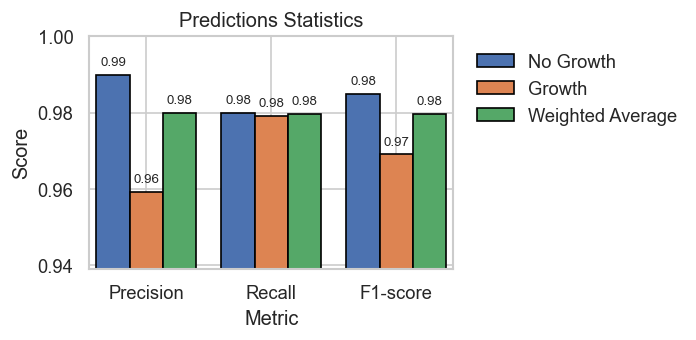

In [7]:
# build metrics + plot 
# requires biolog_data_with_predictions with columns: 'Growth' (y_true) and 'Prediction' (y_pred)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# 1) Inputs and basic settings
# ----------------------------
df = biolog_data_with_predictions.copy()
y_true_col = "Growth"
y_pred_col = "Prediction"

# Optional: map numeric classes to readable names (edit if your labels differ)
class_name_map = {0.0: "No Growth", 1.0: "Growth"}

# Fix dtype/values (robust to ints/floats/strings)
y_true = pd.to_numeric(df[y_true_col], errors="coerce")
y_pred = pd.to_numeric(df[y_pred_col], errors="coerce")

# Ensure both classes appear in fixed order (so the confusion matrix shape is stable)
fixed_classes = sorted(class_name_map.keys())  # e.g., [0.0, 1.0]

# ----------------------------
# 2) Confusion matrix (auto)
# ----------------------------
cm = confusion_matrix(y_true, y_pred, labels=fixed_classes)
cm_df = pd.DataFrame(
    cm,
    index=[f"True {class_name_map[c]}" for c in fixed_classes],
    columns=[f"Pred {class_name_map[c]}" for c in fixed_classes],
)
print("Confusion Matrix:")
print(cm_df.to_string())

# ----------------------------
# 3) Classification report (auto)
# ----------------------------
# Use target_names to get readable keys; output_dict=True gives a dict we can parse
target_names = [class_name_map[c] for c in fixed_classes]
report_dict = classification_report(
    y_true, y_pred, labels=fixed_classes, target_names=target_names, output_dict=True
)

# Build a tidy (long) DataFrame with per-class metrics
per_class_rows = []
for cname in target_names:
    metrics = report_dict.get(cname, {})
    support = int(metrics.get("support", 0))
    for metric in ("precision", "recall", "f1-score"):
        score = float(metrics.get(metric, np.nan))
        per_class_rows.append(
            {"Metric": metric.capitalize(), "Score": score, "Class": cname, "Support": support}
        )

# Weighted average (already provided by sklearn)
wa = report_dict.get("weighted avg", {})
wa_rows = [
    {"Metric": "Precision", "Score": float(wa.get("precision", np.nan)), "Class": "Weighted Average", "Support": int(wa.get("support", 0))},
    {"Metric": "Recall",    "Score": float(wa.get("recall", np.nan)),    "Class": "Weighted Average", "Support": int(wa.get("support", 0))},
    {"Metric": "F1-score",  "Score": float(wa.get("f1-score", np.nan)),  "Class": "Weighted Average", "Support": int(wa.get("support", 0))},
]

metrics_df = pd.DataFrame(per_class_rows + wa_rows)

# Pretty print the tabular report (optional)
print("\nPer-class & weighted metrics:")
print(metrics_df.to_string(index=False))

# ----------------------------
# 4) Plot (pure matplotlib; no seaborn)
# ----------------------------
# We’ll produce a grouped bar chart: X = Metric, groups = classes (including Weighted Average)
ordered_metrics = ["Precision", "Recall", "F1-score"]
plot_df = metrics_df[metrics_df["Metric"].isin(ordered_metrics)].copy()

classes_for_plot = plot_df["Class"].unique().tolist()
num_metrics = len(ordered_metrics)
num_classes = len(classes_for_plot)

# Bar layout
x = np.arange(num_metrics)  # positions for metrics
width = 0.8 / max(num_classes, 1)  # bar width
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)

# Determine y-limits dynamically but keep near [0,1]
ymin = max(0.0, plot_df["Score"].min() - 0.02)
ymax = min(1.0, max(0.98, plot_df["Score"].max() + 0.02))

for i, cls in enumerate(classes_for_plot):
    scores = [plot_df[(plot_df["Metric"] == m) & (plot_df["Class"] == cls)]["Score"].values
              for m in ordered_metrics]
    # Ensure each metric has a single value or NaN
    scores = [s[0] if len(s) else np.nan for s in scores]
    bar_positions = x + (i - (num_classes - 1) / 2.0) * width
    bars = ax.bar(bar_positions, scores, width=width, label=cls, edgecolor="black", linewidth=1)

    # Annotate each bar
    for b in bars:
        height = b.get_height()
        if not np.isnan(height):
            ax.annotate(f"{height:.2f}",
                        xy=(b.get_x() + b.get_width() / 2, height),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha="center", va="bottom", fontsize=8)

ax.set_title("Predictions Statistics")
ax.set_xlabel("Metric")
ax.set_ylabel("Score")
ax.set_xticks(x)
ax.set_xticklabels(ordered_metrics)
ax.set_ylim(ymin, ymax)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False)
ax.margins(x=0.02)

plt.tight_layout()
#plt.savefig('/Users/omidard/Desktop/Stats_confusion.svg', dpi=300, bbox_inches='tight')
plt.show()


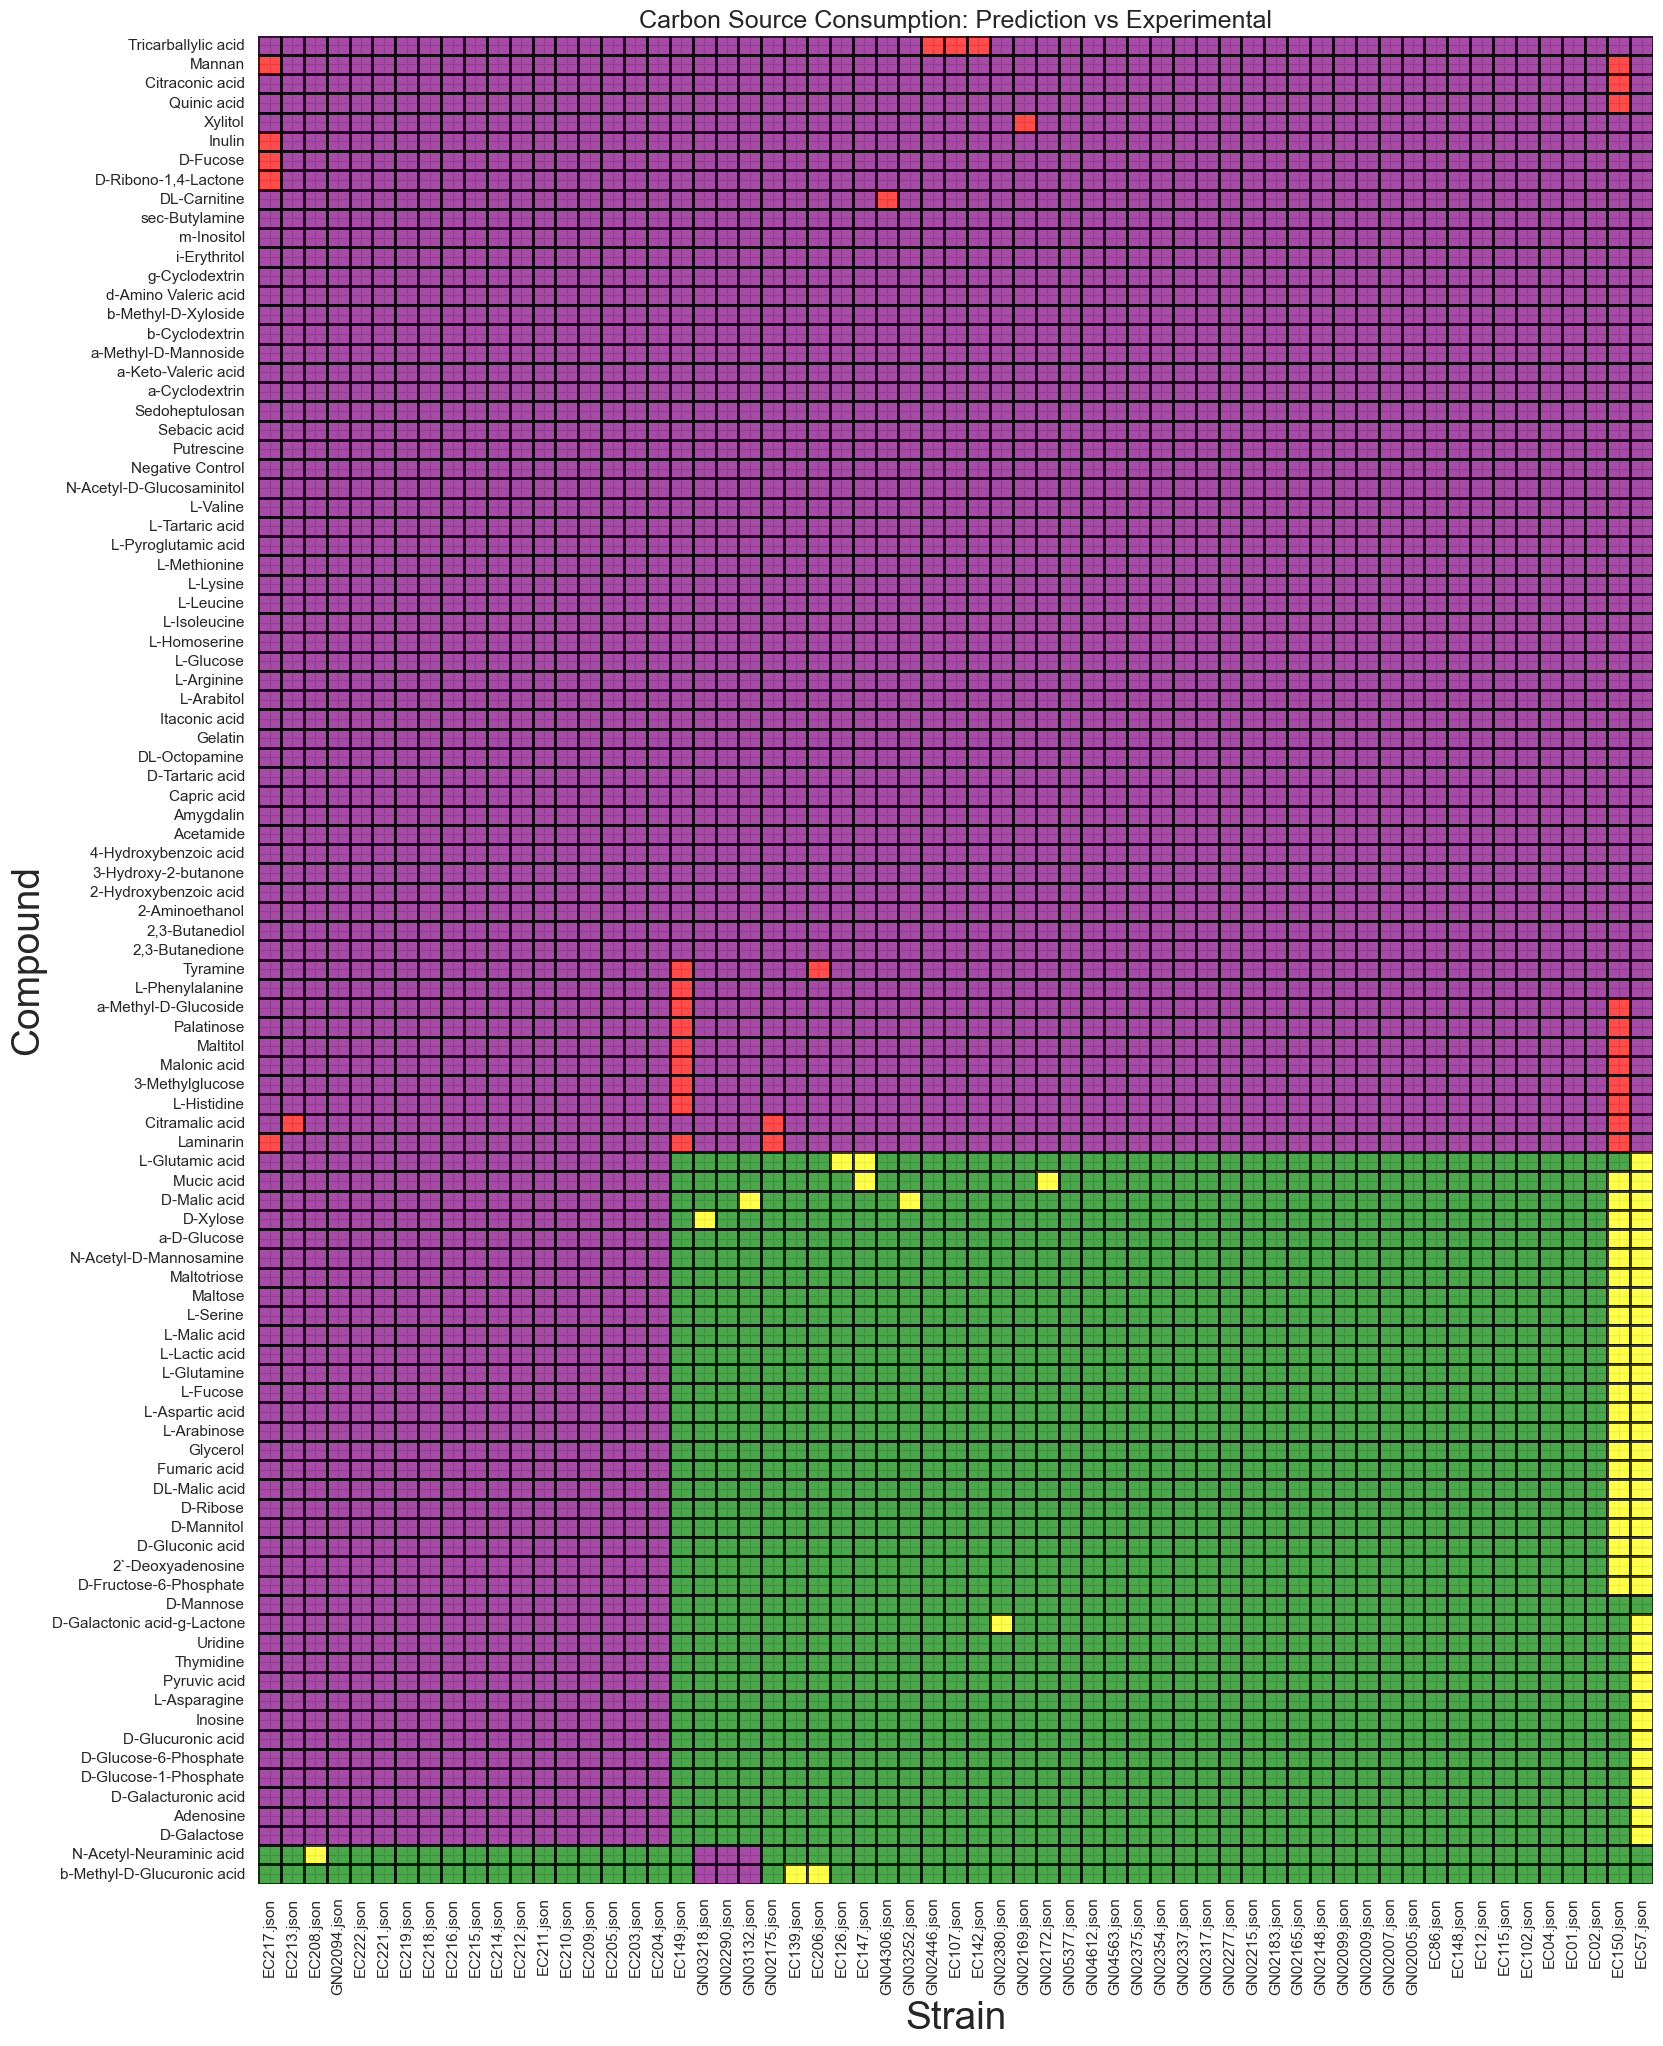

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import numpy as np
import matplotlib
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform
from matplotlib.cm import ScalarMappable


# Assuming pass_ess is your DataFrame and is already loaded
matplotlib.rcParams.update({'font.size': 12})

# Assuming biolog_df_m9_filtered is loaded and contains the necessary columns

# Step 1: Identify the outcomes
def classify_outcome(row):
    if row['Growth'] == row['Prediction']:
        return 0 if row['Growth'] == 0 else 3  # 0: TN, 3: TP
    else:
        return 1 if row['Growth'] == 0 else 2  # 1: FP, 2: FN

biolog_data_with_predictions['Outcome'] = biolog_data_with_predictions.apply(classify_outcome, axis=1)

# Step 2: Pivot the DataFrame
heatmap_data = biolog_data_with_predictions.pivot_table(index='Compound', columns='Strain', values='Outcome', aggfunc='first', fill_value=0)

# Step 3: Create a custom colormap
cmap = ListedColormap(['purple', 'yellow', 'red', 'green'])
bounds = [0, 1, 2, 3, 4]
norm = Normalize(vmin=0, vmax=3)

# Calculate the pairwise distances and linkage
row_linkage = linkage(pdist(heatmap_data, metric='hamming'), method='average')
col_linkage = linkage(pdist(heatmap_data.T, metric='hamming'), method='average')

# Reorder rows and columns according to the clustering
heatmap_data = heatmap_data.iloc[leaves_list(row_linkage), :]
heatmap_data = heatmap_data.iloc[:, leaves_list(col_linkage)]

# Now plot using the original heatmap approach
plt.figure(figsize=(18, 24))
ax = sns.heatmap(heatmap_data, cmap=cmap, norm=norm, cbar=False, alpha=0.7, linewidth=0.9, linecolor='black')

# Rest of the plotting code as above
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#colorbar = plt.colorbar(sm, ticks=[0.375, 1.125, 1.875, 2.625])
#colorbar.set_ticklabels(['True Negative', 'False Positive', 'False Negative', 'True Positive'], fontsize=18)
plt.title('Carbon Source Consumption: Prediction vs Experimental', fontsize=18)
plt.xlabel('Strain', fontsize=28)
#plt.xticks([])
plt.ylabel('Compound', fontsize=28)
#plt.savefig('/Users/omidard/Desktop/pred_vs_exp_heatmap_pancoligems.svg', dpi=300, bbox_inches='tight')
plt.show()

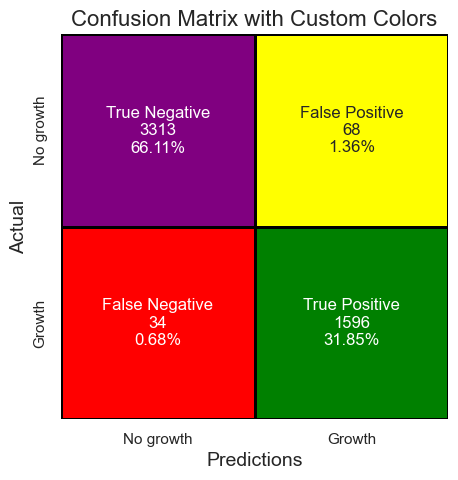

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, Normalize

# Define the custom colormap
cmap = ListedColormap(['purple', 'yellow', 'red', 'green'])
norm = Normalize(vmin=0, vmax=3)
confusion_matrix = cm

# Annotations
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)


# Map each outcome to a specific color
data_mapped = np.array([
    [0, 1],  # TN, FP
    [2, 3]   # FN, TP
])

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(data_mapped, annot=labels, fmt='', cmap=cmap, norm=norm, ax=ax, cbar=False,linewidth=0.9,linecolor='black')


# Setting axis labels
ax.set_xlabel('Predictions', fontsize=14)
ax.set_ylabel('Actual', fontsize=14)
ax.set_xticklabels(['No growth', 'Growth'])
ax.set_yticklabels(['No growth', 'Growth'])
plt.title('Confusion Matrix with Custom Colors', fontsize=16)
#plt.savefig('/Users/omidard/Desktop/confusion_marix.png', dpi=300, bbox_inches='tight')
plt.show()


# Step 4: panGPRs analysis

In [ ]:
"""
eco_gems_allels.py — runner (Jupyter)

Purpose
- Execute an existing script that maps model gene IDs to allele/group IDs and
  builds a reaction × GEM matrix of GPR lists.

Script I/O (as defined inside the script)
- Input mapping:   /home/omidard/header_to_allele.pickle
- Input models:    /home/omidard/gapfilled3/*.json  (referenced via model_folder)
- Input list:      complete_gems.csv  (column 'gems'; filenames of models to load)
- Output table:    /home/omidard/ecoli_gprs.csv

Requirements
- Python packages: cobra, pandas, tqdm
"""

from pathlib import Path
import sys
import subprocess
import pandas as pd

# Paths used by the script (adjust only if the .py is stored elsewhere)
SCRIPT          = Path("/home/omidard/eco_gems_allels.py")
MAPPING_PKL     = Path("/home/omidard/header_to_allele.pickle")
MODEL_DIR       = Path("/home/omidard/gapfilled3")
GEMS_LIST_CSV   = Path("complete_gems.csv")             # resolved relative to current notebook working dir
OUT_CSV         = Path("/home/omidard/ecoli_gprs.csv")

# Sanity checks
assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
assert MAPPING_PKL.exists(), f"Mapping pickle not found: {MAPPING_PKL}"
assert MODEL_DIR.exists(), f"Model directory not found: {MODEL_DIR}"
assert any(MODEL_DIR.glob("*.json")), f"No *.json models in {MODEL_DIR}"
assert GEMS_LIST_CSV.exists(), f"Model list CSV not found: {GEMS_LIST_CSV}"

# Optional header check for the list CSV
try:
    head = pd.read_csv(GEMS_LIST_CSV, nrows=2, index_col=0)
    assert "gems" in head.columns, "Expected column 'gems' not found in complete_gems.csv"
except Exception as e:
    print(f"Warning: could not verify complete_gems.csv columns ({e}). Proceeding.")

# Execute the script unmodified
print(f"Running: {SCRIPT}")
proc = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# Output pointer and brief preview
if OUT_CSV.exists():
    print(f"Output written: {OUT_CSV}")
    try:
        display(pd.read_csv(OUT_CSV, nrows=5))
    except Exception as e:
        print(f"(Preview unavailable: {e})")
else:
    print(f"(Output not found) {OUT_CSV}")


In [12]:
# load the GPRs presence/absence
import pandas as pd
file_path = "/home/omidard/ecoli_gprs.csv"
# Read the file into a DataFrame
ecoli_pan_gprs = pd.read_csv(file_path)
ecoli_pan_gprs.fillna('Not found',inplace=True)
ecoli_pan_gprs

,Unnamed: 0,12PPDRtex,12PPDStex,13PPDH2,14GLUCANabcpp,14GLUCANtexi,23CAMPtex,23CCMPtex,23CGMPtex,23CUMPtex,...,XYLUtex,XYLabcpp,XYLt2pp,XYLtex,YUMPS,ZN2abcpp,ZN2t3pp,ZN2tpp,ZNabcpp,Zn2tex
0,1033813.3.json.json,"['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...","['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...",['Ecoli_C27728'],"['Ecoli_C51289', 'Ecoli_C30587', 'Ecoli_C16819...",['Ecoli_C22772'],"['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...","['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...","['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...","['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...",...,"['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...","['Ecoli_C27006', 'Ecoli_C16635', 'Ecoli_C39296']",['GAP'],"['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756...",['Ecoli_C46604'],['Ecoli_C4874'],"['Ecoli_C48825', 'Ecoli_C47960']",['Ecoli_C64214'],"['Ecoli_C65914', 'Ecoli_C87585', 'Ecoli_C71430']","['Ecoli_C29968', 'Ecoli_C23968', 'Ecoli_C33756..."
1,1038927.31.json.json,"['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...","['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...",['Ecoli_C27728'],"['Ecoli_C51289', 'Ecoli_C16819', 'Ecoli_C27486...",['Ecoli_C22772'],"['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...","['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...","['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...","['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...",...,"['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...","['Ecoli_C39296', 'Ecoli_C27006', 'Ecoli_C16635']",['Ecoli_C15108'],"['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348...",['Ecoli_C46604'],['Ecoli_C4874'],"['Ecoli_C48825', 'Ecoli_C47960']",['Ecoli_C64214'],"['Ecoli_C40265', 'Ecoli_C71430', 'Ecoli_C65914']","['Ecoli_C23968', 'Ecoli_C29968', 'Ecoli_C34348..."
2,1038927.40.json.json,"['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...","['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...",['Ecoli_C27728'],"['Ecoli_C30587', 'Ecoli_C16819', 'Ecoli_C51289...",['Ecoli_C22772'],"['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...","['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...","['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...","['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...",...,"['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...","['Ecoli_C27006', 'Ecoli_C16635', 'Ecoli_C39296']",['Ecoli_C15108'],"['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968...",['Ecoli_C46604'],['Ecoli_C4874'],"['Ecoli_C48825', 'Ecoli_C47960']",['Ecoli_C64214'],"['Ecoli_C65914', 'Ecoli_C40265', 'Ecoli_C71430']","['Ecoli_C33756', 'Ecoli_C23968', 'Ecoli_C29968..."
3,1038927.41.json.json,"['b0929', 'b0241', 'b2215', 'b1377']","['b0929', 'b0241', 'b2215', 'b1377']",['b3011'],"['b4034', 'b4035', 'b4032', 'b4033']",['b4036'],"['b0929', 'b0241', 'b2215', 'b1377']","['b0929', 'b0241', 'b2215', 'b1377']","['b0929', 'b0241', 'b2215', 'b1377']","['b0929', 'b0241', 'b2215', 'b1377']",...,"['b0929', 'b0241', 'b2215', 'b1377']","['b3567', 'b3566', 'b3568']",['b4031'],"['b0929', 'b0241', 'b2215', 'b1377']",['b2165'],['b3469'],"['b3915', 'b0752']",['b3040'],"['b1857', 'b1858', 'b1859']","['b0929', 'b0241', 'b2215', 'b1377']"
4,1038927.45.json.json,"['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...","['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...",['Ecoli_C27728'],"['Ecoli_C16819', 'Ecoli_C51289', 'Ecoli_C27486...",['Ecoli_C22772'],"['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...","['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...","['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...","['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...",...,"['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...","['Ecoli_C39296', 'Ecoli_C27006', 'Ecoli_C16635']",['Ecoli_C15108'],"['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968...",['Ecoli_C46604'],['Ecoli_C4874'],"['Ecoli_C47960', 'Ecoli_C48825']",['Ecoli_C64214'],"['Ecoli_C65914', 'Ecoli_C71430', 'Ecoli_C40265']","['Ecoli_C34348', 'Ecoli_C33756', 'Ecoli_C29968..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2372,GCF_905332355.1.json.json,"['Ec

In [13]:
# Load the pangenome of E.coli
import pandas as pd
file_path = '/home/omidard/pangenome.csv'
pangenome_df = pd.read_csv(file_path)
pangenome_df.drop(columns=['Essential'],inplace=True)
pangenome_df.columns = ['locus_tag','Gene','Category']
pangenome_df

,locus_tag,Gene,Category
0,EPJPPNAH_02825,Ecoli_C6620,Core
1,EPJPPNAH_00232,Ecoli_C34348,Rare
2,EPJPPNAH_00920,Ecoli_C29968,Accessory
3,EPJPPNAH_01370,Ecoli_C23968,Rare
4,EPJPPNAH_02206,Ecoli_C33756,Core
...,...,...,...
10809018,BELAINIL_03275,Ecoli_C40265,Core
10809019,BELAINIL_01264,Ecoli_C34348,Rare
10809020,BELAINIL_02060,Ecoli_C29968,Accessory
10809021,BELAINIL_02729,Ecoli_C23968,Rare


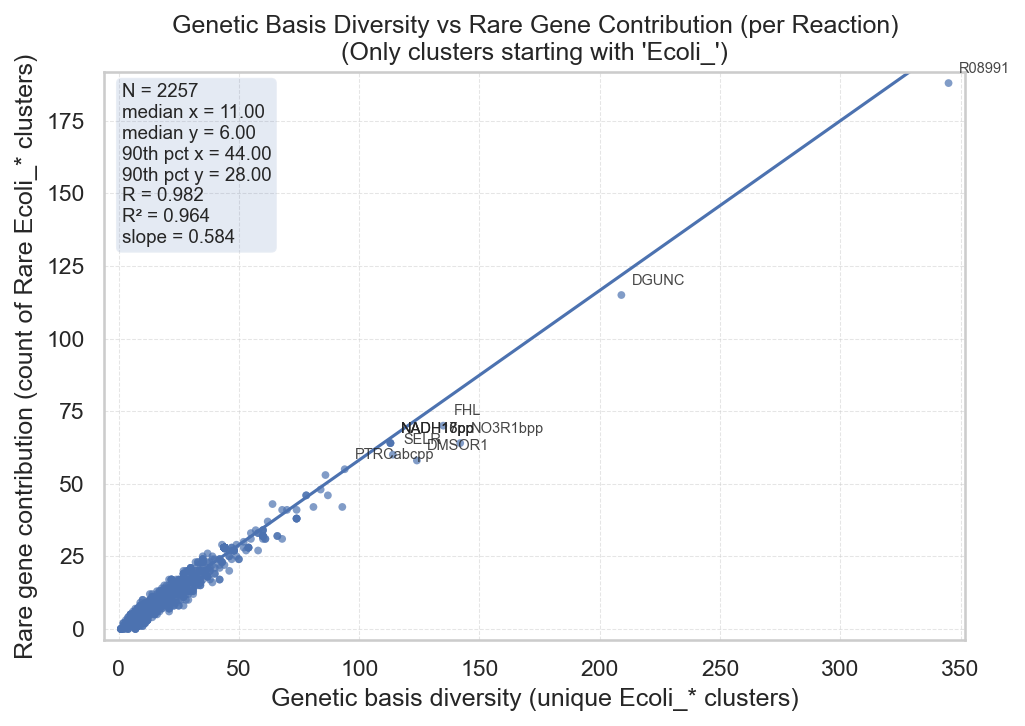

In [15]:
# Update: only count gene clusters that START WITH "Ecoli_"
# Inputs already loaded:
#   ecoli_pan_gprs : DataFrame (genomes x reactions; cells = lists or stringified lists)
#   pangenome_df   : DataFrame with columns ['locus_tag','Gene','Category']

import pandas as pd
import numpy as np
import ast
from collections import Counter
import math
import matplotlib.pyplot as plt

# ---------------------------
# 0) Config
# ---------------------------
IDX_COL_CANDIDATES = {"Unnamed: 0", "index", "genome", "Genome"}
GAP_TOKENS = {"GAP", "[GAP]", "['GAP']", '["GAP"]'}
KEEP_PREFIX = "Ecoli_"      # << strict requirement

ANNOTATE_TOP_N = 10

# ---------------------------
# 1) Utilities
# ---------------------------
def _safe_to_list(cell):
    """Robustly parse a cell into a Python list of strings."""
    if cell is None or (isinstance(cell, float) and math.isnan(cell)):
        return []
    if isinstance(cell, (list, tuple, set)):
        return list(cell)
    if isinstance(cell, str):
        s = cell.strip()
        if s in GAP_TOKENS:
            return []
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, (list, tuple, set)):
                    return list(parsed)
            except Exception:
                pass
        return [s]
    return [str(cell)]

def _clean_and_filter(tokens):
    """
    - Drop GAP-like tokens
    - Keep ONLY clusters that start with 'Ecoli_'
    """
    out = []
    for t in tokens:
        if t is None:
            continue
        ts = str(t).strip().strip('"').strip("'")
        if not ts or ts in GAP_TOKENS or ts.upper() == "GAP":
            continue
        if ts.startswith(KEEP_PREFIX):
            out.append(ts)
    return out

def union_unique_clusters(series):
    """Union of unique, filtered cluster IDs across a reaction column."""
    uniq = set()
    for cell in series:
        tokens = _clean_and_filter(_safe_to_list(cell))
        uniq.update(tokens)
    return uniq

# ---------------------------
# 2) Prep inputs
# ---------------------------
reaction_cols = [c for c in ecoli_gprs_test_curated.columns if c not in IDX_COL_CANDIDATES]

# Gene -> Category map
gene_to_cat = (
    pangenome_df[["Gene", "Category"]]
    .dropna(subset=["Gene", "Category"])
    .drop_duplicates(subset=["Gene"], keep="first")
    .set_index("Gene")["Category"]
    .to_dict()
)

# ---------------------------
# 3) Metrics per reaction
# ---------------------------
records = []
for rxn in reaction_cols:
    uniq = union_unique_clusters(ecoli_gprs_test_curated[rxn])  # ONLY Ecoli_* kept
    total = len(uniq)

    if total == 0:
        counts = Counter()
    else:
        cats = [gene_to_cat.get(g, "Unknown") for g in uniq]
        counts = Counter(cats)

    core = counts.get("Core", 0)
    accessory = counts.get("Accessory", 0)
    rare = counts.get("Rare", 0)
    unknown = counts.get("Unknown", 0)

    records.append({
        "reaction": rxn,
        "genetic_basis_diversity": total,     # x
        "rare_gene_contribution": rare,       # y
        "core_count": core,
        "accessory_count": accessory,
        "unknown_count": unknown,
        "core_frac": core / total if total else np.nan,
        "accessory_frac": accessory / total if total else np.nan,
        "rare_frac": rare / total if total else np.nan,
        "unknown_frac": unknown / total if total else np.nan,
    })

results_df = pd.DataFrame.from_records(records)
results_df = results_df[results_df["genetic_basis_diversity"] > 0].reset_index(drop=True)

# ---------------------------
# 4) Scatter plot
# ---------------------------
x = results_df["genetic_basis_diversity"].astype(float).values
y = results_df["rare_gene_contribution"].astype(float).values

if len(results_df) >= 2 and np.nanstd(x) > 0 and np.nanstd(y) > 0:
    m, b = np.polyfit(x, y, 1)
    y_fit = m * x + b
    r = np.corrcoef(x, y)[0, 1]
    r2 = r**2
else:
    m = b = r = r2 = np.nan
    y_fit = np.full_like(x, np.nan)

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

ax.scatter(x, y, s=14, alpha=0.7, edgecolors="none")

if np.isfinite(m) and np.isfinite(b):
    xline = np.linspace(np.nanmin(x), np.nanmax(x), 200)
    yline = m * xline + b
    ax.plot(xline, yline, linewidth=1.5)

ax.set_title("Genetic Basis Diversity vs Rare Gene Contribution (per Reaction)\n(Only clusters starting with 'Ecoli_')")
ax.set_xlabel("Genetic basis diversity (unique Ecoli_* clusters)")
ax.set_ylabel("Rare gene contribution (count of Rare Ecoli_* clusters)")

x_pad = max(1.0, 0.02 * (np.nanmax(x) - np.nanmin(x) + 1))
y_pad = max(1.0, 0.02 * (np.nanmax(y) - np.nanmin(y) + 1))
ax.set_xlim(np.nanmin(x) - x_pad, np.nanmax(x) + x_pad)
ax.set_ylim(np.nanmin(y) - y_pad, np.nanmax(y) + y_pad)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
ax.margins(x=0.02, y=0.05)

N = len(results_df)
stats_text = [
    f"N = {N}",
    f"median x = {np.nanmedian(x):.2f}",
    f"median y = {np.nanmedian(y):.2f}",
    f"90th pct x = {np.nanpercentile(x, 90):.2f}",
    f"90th pct y = {np.nanpercentile(y, 90):.2f}",
]
if np.isfinite(r):
    stats_text += [f"R = {r:.3f}", f"R² = {r2:.3f}", f"slope = {m:.3f}"]
ax.text(0.02, 0.98, "\n".join(stats_text),
        transform=ax.transAxes, ha="left", va="top",
        fontsize=9, bbox=dict(boxstyle="round", alpha=0.15))

# Label outliers on both axes
to_label_idx = set()
if N:
    to_label_idx.update(np.argsort(-x)[:ANNOTATE_TOP_N].tolist())
    to_label_idx.update(np.argsort(-y)[:ANNOTATE_TOP_N].tolist())

for i in to_label_idx:
    rxn = results_df.iloc[i]["reaction"]
    ax.annotate(rxn, (x[i], y[i]), xytext=(5, 5),
                textcoords="offset points", fontsize=7, alpha=0.85)

plt.tight_layout()
plt.show()

# Optional saves:
# results_df.to_csv("/home/omidard/genetic_diversity_rare_contribution_per_reaction_EcoliOnly.csv", index=False)
# fig.savefig("/home/omidard/genetic_diversity_vs_rare_contribution_scatter_EcoliOnly.png", dpi=300, bbox_inches="tight")


# Gene neighborhood analysis

In [ ]:
"""
genes_neighborhood_analysis_total_preparation.py — runner (Jupyter)

Purpose
- Run the script that expands pan-genome presence/absence into per-(locus_tag, reaction, genome)
  rows using mapping pickles, then writes a consolidated table.

Script I/O (as defined in the script)
- Inputs (pickles):
  - /home/omidard/neighbors/pa_gene_allt_copy2.pkl
  - /home/omidard/neighbors/locustags_genes_mapping.pkl
  - /home/omidard/neighbors/pangenome_df.pkl
- Output:
  - /home/omidard/neighbors/final_gene_neighborhood.csv

Requirements
- pandas, numpy, tqdm; multiprocessing from stdlib.
"""

from pathlib import Path
import sys
import subprocess
import pandas as pd

# Paths
SCRIPT = Path("/home/omidard/genes_neighborhood_analysis_total_preparation.py")
P1 = Path("/home/omidard/neighbors/pa_gene_allt_copy2.pkl")
P2 = Path("/home/omidard/neighbors/locustags_genes_mapping.pkl")
P3 = Path("/home/omidard/neighbors/pangenome_df.pkl")
OUT = Path("/home/omidard/neighbors/final_gene_neighborhood.csv")

# Sanity checks
assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
for p in (P1, P2, P3):
    assert p.exists(), f"Missing input: {p}"

# Execute unmodified script
print(f"Running: {SCRIPT}")
proc = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# Output pointer and quick preview
if OUT.exists():
    print(f"Output written: {OUT}")
    try:
        display(pd.read_csv(OUT, nrows=10))
    except Exception as e:
        print(f"(Preview unavailable: {e})")
else:
    print(f"(Output not found) {OUT}")


In [ ]:
"""
genes_neighborhood_analysis_total_preparation.py — runner (Jupyter)

Purpose
- Execute a script that scans GenBank genomes to extract upstream/downstream neighbors
  for target locus_tags and writes a joined table.

Script I/O (as defined in the script)
- Inputs:
  - /home/omidard/neighbors/final_gene_neighborhood.csv     # required columns: locus_tag, gene_name, category, genome_id, reaction
  - /home/omidard/prokka_genomes/*.gbk                      # genome files
- Output:
  - /home/omidard/neighbors/all_reactions_gene_neighborhood.csv

Notes
- Packages used by the script: pandas, biopython (SeqIO), tqdm, multiprocessing.
- The script launches with a pool size of 96; adjust system limits if needed.
"""

from pathlib import Path
import sys
import subprocess
import pandas as pd

# Paths used by the script (edit only if the .py is elsewhere)
SCRIPT             = Path("/home/omidard/genes_neighborhood_analysis_total_preparation.py")
INPUT_TABLE        = Path("/home/omidard/neighbors/final_gene_neighborhood.csv")
GENOMES_DIR        = Path("/home/omidard/prokka_genomes")
OUTPUT_TABLE       = Path("/home/omidard/neighbors/all_reactions_gene_neighborhood.csv")

# Sanity checks
assert SCRIPT.exists(), f"Script not found: {SCRIPT}"
assert INPUT_TABLE.exists(), f"Input table not found: {INPUT_TABLE}"
assert GENOMES_DIR.exists(), f"Genomes directory not found: {GENOMES_DIR}"
assert any(GENOMES_DIR.glob("*.gbk")), f"No .gbk files found in {GENOMES_DIR}"

# Optional header check for key columns
try:
    head = pd.read_csv(INPUT_TABLE, nrows=3)
    required = {"locus_tag", "gene_name", "category", "genome_id", "reaction"}
    missing = required - set(head.columns)
    if missing:
        print(f"WARNING: input CSV missing expected columns: {sorted(missing)}")
except Exception as e:
    print(f"WARNING: could not inspect input CSV header ({e}). Proceeding.")

# Run the script unmodified
print(f"Running: {SCRIPT}")
proc = subprocess.run([sys.executable, str(SCRIPT)])
print("Return code:", proc.returncode)
if proc.returncode != 0:
    raise SystemExit(proc.returncode)

# Output pointer and brief preview
if OUTPUT_TABLE.exists():
    print(f"Output written: {OUTPUT_TABLE}")
    try:
        display(pd.read_csv(OUTPUT_TABLE, nrows=10))
    except Exception as e:
        print(f"(Preview unavailable: {e})")
else:
    print(f"(Output not found) {OUTPUT_TABLE}")


In [49]:
# Load the output datafram (all_reactions_gene_neighborhood.csv) produced by genes_neighborhood_analysis_total2.py

import pandas as pd
import re
from zipfile import ZipFile



file_path = "/Users/omidard/Desktop/Data/neighborhood/all_reactions_gene_neighborhood.csv.zip"

with ZipFile(file_path) as zf:
    names = [n for n in zf.namelist()
             if n.lower().endswith(".csv") and not n.startswith("__MACOSX/")]
    assert len(names) >= 1, f"No CSV found (found: {zf.namelist()})"
    with zf.open(names[0]) as fh:
        ngn = pd.read_csv(fh, low_memory=False)



ngn.drop(columns=['Downstream_Gene_2','Upstream_Gene_2','reaction','genome_id'],inplace=True)
# Remove duplicated rows based on the 'locus_tag' column
ngn = ngn.drop_duplicates(subset=['locus_tag'])
ngn.drop(columns=['locus_tag'],inplace=True)

# Function to extract gene name
def extract_gene_name(value):
    # Regular expression to capture text after 'gene=' and stop at the next space or bracket
    match = re.search(r'gene=([^\s\]]+)', str(value))
    if match:
        return match.group(1)  # Return the captured gene name
    else:
        return value  # Return the original value if no gene= found

# Function to clean the DataFrame
def clean_gene_columns(df, columns):
    for col in columns:
        df[col] = df[col].apply(extract_gene_name)
    return df

# Define the columns to clean
columns_to_clean = ['Downstream_Gene_1', 'Target_Gene', 'Upstream_Gene_1']

# Clean the DataFrame
cleaned_ngn = clean_gene_columns(ngn.copy(), columns_to_clean)

# Display the cleaned DataFrame
cleaned_ngn["Reaction"] = cleaned_ngn["Reaction"].replace({"R08991": "CDGUNPD"})
cleaned_ngn


,gene_name,category,Downstream_Gene_1,Target_Gene,Upstream_Gene_1,Reaction
0,Ecoli_C33756,Accessory,ftp,ompC,rcsD,12PPDRtex
1,Ecoli_C34348,Accessory,crl,phoE,proB,12PPDRtex
2,Ecoli_C29968,Accessory,aspC,ompF,asnS,12PPDRtex
3,Ecoli_C23968,Accessory,uspF,ompN,ydbK,12PPDRtex
4,Ecoli_C34348,Accessory,crl,phoE,proB,12PPDRtex
...,...,...,...,...,...,...
10335769,Ecoli_C71430,Core,znuB,znuC,znuA,ZNabcpp
10335770,Ecoli_C40265,Core,znuC,znuA,mepM,ZNabcpp
10335771,Ecoli_C65914,Core,ruvB,znuB,znuC,ZNabcpp
10335772,Ecoli_C71430,Core,znuB,znuC,znuA,ZNabcpp


In [50]:
# Fix: assign labels AFTER filtering, so lengths match

import numpy as np
import pandas as pd

# Clean strings (avoid NaN=='nan')
s_ds = cleaned_ngn["Downstream_Gene_1"].astype(str).str.strip()
s_tg = cleaned_ngn["Target_Gene"].astype(str).str.strip()
s_us = cleaned_ngn["Upstream_Gene_1"].astype(str).str.strip()

# Treat empty/na-like strings as missing
nullish = {"", "nan", "None", "NaN", "NAN"}
m1 = (~s_ds.isin(nullish)) & (~s_tg.isin(nullish)) & s_ds.eq(s_tg)  # Downstream == Target
m2 = (~s_tg.isin(nullish)) & (~s_us.isin(nullish)) & s_tg.eq(s_us)  # Target == Upstream

mask = m1 | m2

pseudogens = cleaned_ngn.loc[mask].copy()
# Default label "Both" for rows where both equalities hold
pseudogens["pseudogene_pair"] = "Both"

# Assign specific labels using the SAME index (no length mismatch)
pseudogens.loc[m1[mask] & ~m2[mask], "pseudogene_pair"] = "Downstream==Target"
pseudogens.loc[m2[mask] & ~m1[mask], "pseudogene_pair"] = "Target==Upstream"

# Optional sanity checks
# print(pseudogens["pseudogene_pair"].value_counts(dropna=False))
# pseudogens.head()
pseudogens

,gene_name,category,Downstream_Gene_1,Target_Gene,Upstream_Gene_1,Reaction,pseudogene_pair
38,Ecoli_C85030,Rare,ftp,ompC,ompC,12PPDRtex,Target==Upstream
68,Ecoli_C36971,Rare,ydbK,ompN,ompN,12PPDRtex,Target==Upstream
92,Ecoli_C66123,Accessory,uspF,ompN,ompN,12PPDRtex,Target==Upstream
151,Ecoli_C52520,Rare,ompF,ompF,asnS,12PPDRtex,Downstream==Target
187,Ecoli_C66123,Accessory,ompN,ompN,uspF,12PPDRtex,Downstream==Target
...,...,...,...,...,...,...,...
10332040,Ecoli_C196480,Rare,znuC,znuC,znuB,ZNabcpp,Downstream==Target
10332240,Ecoli_C191190,Rare,znuB,znuB,znuC,ZNabcpp,Downstream==Target
10333816,Ecoli_C196480,Rare,znuC,znuC,znuB,ZNabcpp,Downstream==Target
10334773,Ecoli_C130590,Rare,znuA,znuC,znuC,ZNabcpp,Target==Upstream


In [51]:
pseudogens = pseudogens[pseudogens['category']=='Rare']

# Fast, safe, and readable: vectorized update (no loops)

# Option 1 — simplest
pseudogens["Reaction"] = pseudogens["Reaction"].replace({"R08991": "CDGUNPD"})
pseudogens

/var/folders/g4/gzd2bm953vs0rn_qkz4wyd1w0000gp/T/ipykernel_22374/3733006781.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudogens["Reaction"] = pseudogens["Reaction"].replace({"R08991": "CDGUNPD"})


,gene_name,category,Downstream_Gene_1,Target_Gene,Upstream_Gene_1,Reaction,pseudogene_pair
38,Ecoli_C85030,Rare,ftp,ompC,ompC,12PPDRtex,Target==Upstream
68,Ecoli_C36971,Rare,ydbK,ompN,ompN,12PPDRtex,Target==Upstream
151,Ecoli_C52520,Rare,ompF,ompF,asnS,12PPDRtex,Downstream==Target
194,Ecoli_C66764,Rare,ydbK,ompN,ompN,12PPDRtex,Target==Upstream
195,Ecoli_C124450,Rare,phoE,phoE,hypothetical protein,12PPDRtex,Downstream==Target
...,...,...,...,...,...,...,...
10332040,Ecoli_C196480,Rare,znuC,znuC,znuB,ZNabcpp,Downstream==Target
10332240,Ecoli_C191190,Rare,znuB,znuB,znuC,ZNabcpp,Downstream==Target
10333816,Ecoli_C196480,Rare,znuC,znuC,znuB,ZNabcpp,Downstream==Target
10334773,Ecoli_C130590,Rare,znuA,znuC,znuC,ZNabcpp,Target==Upstream


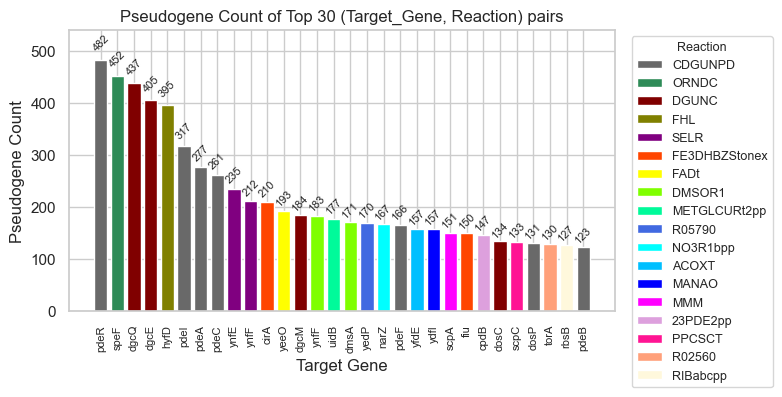

In [52]:
# Visualize pseudogenes like your previous plot, but using the `pseudogens` df
# Assumes `pseudogens` has columns: ['gene_name','category','Downstream_Gene_1','Target_Gene','Upstream_Gene_1','Reaction','pseudogene_pair']

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
from itertools import cycle

# 1) Custom palette (as before)
palette = {
    'dimgray':              '#696969',
    'seagreen':             '#2e8b57',
    'maroon':               '#800000',
    'olive':                '#808000',
    'purple':               '#800080',
    'orangered':            '#ff4500',
    'yellow':               '#ffff00',
    'chartreuse':           '#7fff00',
    'mediumspringgreen':    '#00fa9a',
    'royalblue':            '#4169e1',
    'aqua':                 '#00ffff',
    'deepskyblue':          '#00bfff',
    'blue':                 '#0000ff',
    'fuchsia':              '#ff00ff',
    'plum':                 '#dda0dd',
    'deeppink':             '#ff1493',
    'lightsalmon':          '#ffa07a',
    'cornsilk':             '#fff8dc',
}

# 2) Aggregate pseudogene counts per (Target_Gene, Reaction)
frag = (
    pseudogens
    .groupby(['Target_Gene', 'Reaction'], dropna=False)
    .size()
    .reset_index(name='pseudogene_count')
    .sort_values('pseudogene_count', ascending=False)
)

# 3) Take top 30 rows
df30 = frag.head(30).copy()

# 4) Map each Reaction to a unique palette color (cycle if more reactions than colors)
unique_rxns = df30['Reaction'].astype(str).unique().tolist()
color_names = list(palette.keys())
color_iter = cycle(color_names)
color_map = {}
for rxn in unique_rxns:
    # assign next available color (reuse if more rxns than palette size)
    name = next(color_iter)
    color_map[rxn] = palette[name]

# 5) Prepare x positions for the bars
x = range(len(df30))

# 6) Create the bar plot
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(
    x,
    df30['pseudogene_count'].values,
    color=[color_map[str(rxn)] for rxn in df30['Reaction'].astype(str)],
    align='center'
)

# 7) Annotate y-values on all bars (first 30)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(1, 0.03 * height),
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=8,
        rotation=45
    )

# 8) Label axes and title
ax.set_xlabel('Target Gene')
ax.set_ylabel('Pseudogene Count')
ax.set_title('Pseudogene Count of Top 30 (Target_Gene, Reaction) pairs')

# 9) Set x-ticks to gene names
ax.set_xticks(list(x))
ax.set_xticklabels(df30['Target_Gene'].astype(str), rotation=90, fontsize=8)
ax.set_ylim(0, df30['pseudogene_count'].max() * 1.12)

# 10) Add a legend for Reaction colors
legend_handles = [Patch(facecolor=color_map[str(rxn)], label=str(rxn)) for rxn in unique_rxns]
ax.legend(
    handles=legend_handles,
    title='Reaction',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=9,
    title_fontsize=9
)

plt.tight_layout()
# plt.savefig('/Users/omidard/Desktop/pseudogenes_top30.svg', dpi=800, bbox_inches='tight')
plt.show()


In [53]:
# removing pseudogenes before calculating genetic basis diversity of reactions
cleaned_ngn_intact = cleaned_ngn.drop(index=pseudogens.index, errors="ignore")
cleaned_ngn_intact

,gene_name,category,Downstream_Gene_1,Target_Gene,Upstream_Gene_1,Reaction
0,Ecoli_C33756,Accessory,ftp,ompC,rcsD,12PPDRtex
1,Ecoli_C34348,Accessory,crl,phoE,proB,12PPDRtex
2,Ecoli_C29968,Accessory,aspC,ompF,asnS,12PPDRtex
3,Ecoli_C23968,Accessory,uspF,ompN,ydbK,12PPDRtex
4,Ecoli_C34348,Accessory,crl,phoE,proB,12PPDRtex
...,...,...,...,...,...,...
10335769,Ecoli_C71430,Core,znuB,znuC,znuA,ZNabcpp
10335770,Ecoli_C40265,Core,znuC,znuA,mepM,ZNabcpp
10335771,Ecoli_C65914,Core,ruvB,znuB,znuC,ZNabcpp
10335772,Ecoli_C71430,Core,znuB,znuC,znuA,ZNabcpp


In [59]:
# calculate the genetic basis diversity of reactions based on intact genes
# Build reactions_genetic_basis from cleaned_ngn_intact
# - genetic_basis_diversity: unique count of gene_name per Reaction
# - pseudogenization: unique count of gene_name per Reaction within `pseudogens`
#   (0 if a Reaction has no pseudogen rows)

import pandas as pd
import numpy as np

# --- helpers ---
def _uniq_count(s: pd.Series) -> int:
    return (
        s.dropna()
         .astype(str).str.strip()
         .replace({"": np.nan})
         .dropna()
         .nunique()
    )

# --- 1) genetic basis (all rows in cleaned_ngn_intact) ---
gb = (
    cleaned_ngn_intact
    .assign(Reaction=lambda d: d["Reaction"].astype(str).str.strip(),
            gene_name=lambda d: d["gene_name"].astype(str).str.strip())
    .groupby("Reaction", as_index=False)["gene_name"]
    .agg(genetic_basis_diversity=_uniq_count)
)

# --- 2) pseudogenization (subset in `pseudogens`) ---
pz = (
    pseudogens
    .assign(Reaction=lambda d: d["Reaction"].astype(str).str.strip(),
            gene_name=lambda d: d["gene_name"].astype(str).str.strip())
    .groupby("Reaction", as_index=False)["gene_name"]
    .agg(pseudogenization=_uniq_count)
)

# --- 3) merge, fill missing pseudogenization with 0 ---
reactions_genetic_basis = (
    gb.merge(pz, on="Reaction", how="left")
      .fillna({"pseudogenization": 0})
)

# ensure integers
reactions_genetic_basis["genetic_basis_diversity"] = reactions_genetic_basis["genetic_basis_diversity"].astype(int)
reactions_genetic_basis["pseudogenization"] = reactions_genetic_basis["pseudogenization"].astype(int)

# Optional: sort by size
reactions_genetic_basis = reactions_genetic_basis.sort_values(
    ["genetic_basis_diversity", "pseudogenization"],
    ascending=[False, False]
).reset_index(drop=True)

# Optional: save
# reactions_genetic_basis.to_csv("/Users/omidard/Desktop/reactions_genetic_basis.csv", index=False)

reactions_genetic_basis

,Reaction,genetic_basis_diversity,pseudogenization
0,CDGUNPD,199,277
1,FHL,94,67
2,DGUNC,91,162
3,DMSOR1,64,82
4,MAN1PT2,54,25
...,...,...,...
1072,NDPK1,1,0
1073,O16AT,1,0
1074,PGPP120pp,1,0
1075,RBFK,1,0


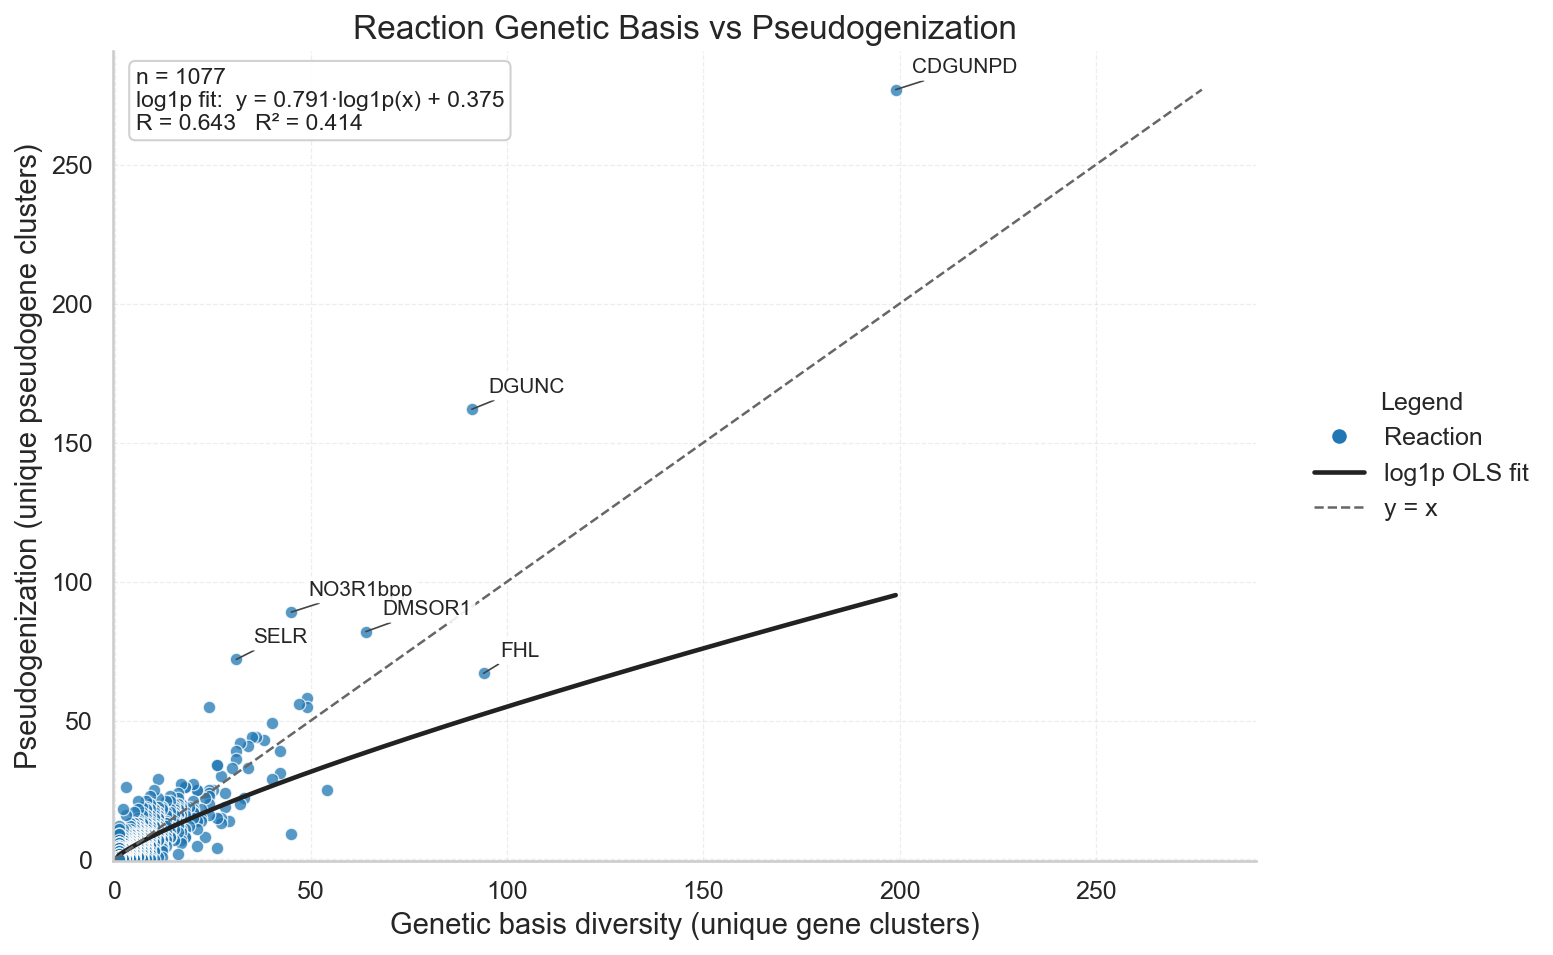

In [63]:
# Polished “journal-style” dot plot for reactions with clearer legend + top-4 annotations
# x = genetic_basis_diversity, y = pseudogenization
# - log1p fit (robust to zeros)
# - large, readable legend outside the axes
# - annotate TOP-4 reactions by y (highest pseudogenization)
# - tidy typography and spacing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- INPUT ---
df = reactions_genetic_basis[['Reaction','genetic_basis_diversity','pseudogenization']].copy()
df = df.dropna()
df['genetic_basis_diversity'] = pd.to_numeric(df['genetic_basis_diversity'], errors='coerce')
df['pseudogenization']        = pd.to_numeric(df['pseudogenization'], errors='coerce')
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# --- Prepare arrays ---
x = df['genetic_basis_diversity'].to_numpy(float)
y = df['pseudogenization'].to_numpy(float)

# Fit in log1p space
tx, ty = np.log1p(x), np.log1p(y)
m, b = np.polyfit(tx, ty, 1)
r = np.corrcoef(tx, ty)[0, 1]
r2 = r**2

# Prediction curve back in original scale
xline = np.linspace(x.min(), x.max(), 400)
yline = np.expm1(m * np.log1p(xline) + b)

# Top-4 by y (highest pseudogenization)
top4_idx = np.argsort(-y)[:6]

# --- Style ---
plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})
dot_color = "#1f77b4"

fig, ax = plt.subplots(figsize=(10.5, 6.5), dpi=150)

# Scatter (bigger, white edge, slight alpha)
ax.scatter(x, y, s=36, c=dot_color, alpha=0.75, edgecolors="white", linewidths=0.6)

# Trend line
ax.plot(xline, yline, color="#222222", linewidth=2.2, label="log1p OLS fit")

# y = x reference
ref_max = max(x.max(), y.max())
ax.plot([0, ref_max], [0, ref_max], color="#666666", linestyle="--", linewidth=1.2, label="y = x")

# Axes & grid
ax.set_xlabel("Genetic basis diversity (unique gene clusters)")
ax.set_ylabel("Pseudogenization (unique pseudogene clusters)")
ax.grid(True, linestyle="--", alpha=0.35, linewidth=0.6)
ax.set_xlim(left=-0.5)
ax.set_ylim(bottom=-0.5)
ax.set_title("Reaction Genetic Basis vs Pseudogenization")

# Stats box (cleaner)
stats = f"n = {len(df)}\nlog1p fit:  y = {m:.3f}·log1p(x) + {b:.3f}\nR = {r:.3f}   R² = {r2:.3f}"
ax.text(0.02, 0.98, stats, transform=ax.transAxes, ha="left", va="top",
        fontsize=11, color="#222", bbox=dict(boxstyle="round,pad=0.28", fc="white", ec="#cccccc", alpha=0.9))

# Annotate TOP-4 by y
for i in top4_idx:
    ax.annotate(
        df.iloc[i]['Reaction'],
        (x[i], y[i]),
        xytext=(8, 8),
        textcoords="offset points",
        fontsize=10,
        weight="regular",
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.9),
        arrowprops=dict(arrowstyle="-", color="#444444", lw=0.8, shrinkA=0, shrinkB=0)
    )

# Legend: create clean handles (dot + fit + ref)
handles = [
    Line2D([0],[0], marker='o', color='none', markerfacecolor=dot_color,
           markeredgecolor="white", markersize=8, label="Reaction"),
    Line2D([0],[0], color="#222222", lw=2.2, label="log1p OLS fit"),
    Line2D([0],[0], color="#666666", lw=1.2, ls="--", label="y = x"),
]
leg = ax.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02, 0.5),
                frameon=False, title="Legend", borderaxespad=1.0)

plt.tight_layout()
# plt.savefig("/Users/omidard/Desktop/reactions_genetic_basis_readable.svg", dpi=600, bbox_inches="tight")
plt.show()


In [55]:
# Build cleaned_ngn_labeled using ONLY cleaned_ngn
# - Labels per Target_Gene from unique category sets
# - Rare-only -> category 'Singleton' and label 'Only rare'
# - Rare+{Core/Accessory} -> rare rows 'Xenolog'; label 'Rare-Acc' / 'Rare-Core' / 'Rare-Core-Acc'
# - Core-only -> label 'Only core'
# - Accessory-only -> label 'Only accessory'
# - Core+Accessory -> label 'Acc-core'
# - Remaining Rare -> 'Pseudogene'

import pandas as pd

# ---- 1) normalize and compute per-gene category sets ----
df_base = cleaned_ngn.copy()
df_base['category'] = (
    df_base['category']
    .astype(str).str.strip().str.replace(r'\s+', ' ', regex=True).str.title()
)

cat_sets = (
    df_base.dropna(subset=['Target_Gene','category'])
           .groupby('Target_Gene')['category']
           .agg(lambda s: set(s))
)

# ---- 2) derive groups of interest ----
singleton_genes = set(cat_sets[cat_sets.apply(lambda s: s == {'Rare'})].index)
xeno_genes = set(cat_sets[cat_sets.apply(lambda s: ('Rare' in s) and (len(s) > 1))].index)

# ---- 3) label mapping (for ALL genes) ----
def label_for_set(s: set) -> str:
    s = set(x.title() for x in s if isinstance(x, str))
    if s == {'Rare'}:                    return 'Only rare'
    if s == {'Core'}:                    return 'Only core'
    if s == {'Accessory'}:               return 'Only accessory'
    if s == {'Core','Accessory'}:        return 'Acc-core'
    if s == {'Rare','Accessory'}:        return 'Rare-Acc'
    if s == {'Rare','Core'}:             return 'Rare-Core'
    if s == {'Rare','Core','Accessory'}: return 'Rare-Core-Acc'
    if 'Rare' in s:                      return 'Rare-' + '-'.join(sorted(s - {'Rare'}))
    return '-'.join(sorted(s)) if s else 'Unknown'

label_map = cat_sets.map(label_for_set).to_dict()

# ---- 4) apply to full cleaned_ngn ----
cleaned_ngn_labeled = df_base.copy()
cleaned_ngn_labeled['labels'] = cleaned_ngn_labeled['Target_Gene'].map(label_map)

# Rename categories on Rare rows
is_rare = cleaned_ngn_labeled['category'].eq('Rare')
cleaned_ngn_labeled.loc[is_rare & cleaned_ngn_labeled['Target_Gene'].isin(singleton_genes), 'category'] = 'Singleton'
cleaned_ngn_labeled.loc[is_rare & cleaned_ngn_labeled['Target_Gene'].isin(xeno_genes),      'category'] = 'Xenolog'

# Remaining Rare -> Pseudogene
cleaned_ngn_labeled.loc[cleaned_ngn_labeled['category'].eq('Rare'), 'category'] = 'Pseudogene'

# Optional sanity checks:
# print(cleaned_ngn_labeled['labels'].value_counts(dropna=False).sort_index())
# print(cleaned_ngn_labeled['category'].value_counts().sort_index())
cleaned_ngn_labeled

,gene_name,category,Downstream_Gene_1,Target_Gene,Upstream_Gene_1,Reaction,labels
0,Ecoli_C33756,Accessory,ftp,ompC,rcsD,12PPDRtex,Rare-Acc
1,Ecoli_C34348,Accessory,crl,phoE,proB,12PPDRtex,Rare-Acc
2,Ecoli_C29968,Accessory,aspC,ompF,asnS,12PPDRtex,Rare-Acc
3,Ecoli_C23968,Accessory,uspF,ompN,ydbK,12PPDRtex,Rare-Acc
4,Ecoli_C34348,Accessory,crl,phoE,proB,12PPDRtex,Rare-Acc
...,...,...,...,...,...,...,...
10335769,Ecoli_C71430,Core,znuB,znuC,znuA,ZNabcpp,Rare-Core
10335770,Ecoli_C40265,Core,znuC,znuA,mepM,ZNabcpp,Rare-Core
10335771,Ecoli_C65914,Core,ruvB,znuB,znuC,ZNabcpp,Rare-Core
10335772,Ecoli_C71430,Core,znuB,znuC,znuA,ZNabcpp,Rare-Core


In [56]:
# Neighborhood stability per (Target_Gene, category) and write back to every row
# Uses ONLY cleaned_ngn_labeled with columns:
# ['Target_Gene','category','Downstream_Gene_1','Upstream_Gene_1', ...]
# Output: cleaned_ngn_labeled['neighborhood_conservation']

import numpy as np
import pandas as pd

df = cleaned_ngn_labeled.copy()

# 0) Normalize strings (robust to None/NaN)
def _norm(s):
    return (
        s.astype(str)
         .str.strip()
         .str.replace(r"\s+", " ", regex=True)
         .replace({"": np.nan, "nan": np.nan, "None": np.nan, "NaN": np.nan}, regex=False)
    )

for col in ["Target_Gene", "category", "Downstream_Gene_1", "Upstream_Gene_1"]:
    if col in df.columns:
        df[col] = _norm(df[col])
    else:
        raise KeyError(f"Missing required column: {col}")

# 1) Helper: set of unique, non-null neighbors from a Series
def _uniq_set(series: pd.Series) -> set:
    vals = series.dropna().astype(str).str.strip()
    vals = vals[vals.ne("")]  # non-empty
    return set(vals.tolist())

# 2) Compute metrics per (Target_Gene, category)
def _metrics(sub: pd.DataFrame) -> pd.Series:
    down = _uniq_set(sub["Downstream_Gene_1"])
    up   = _uniq_set(sub["Upstream_Gene_1"])
    neighbors = down | up
    gsize = len(sub)
    cons = (len(neighbors) / gsize) if gsize > 0 else np.nan
    return pd.Series({
        "unique_downstream": len(down),
        "unique_upstream":   len(up),
        "unique_neighbors":  len(neighbors),
        "group_size":        gsize,
        "neighborhood_conservation": cons
    })

metrics = (
    df.groupby(["Target_Gene", "category"], dropna=False, sort=False)
      .apply(_metrics)
      .reset_index()
)

# 3) Attach conservation to every row
df = df.merge(
    metrics[["Target_Gene", "category", "neighborhood_conservation"]],
    on=["Target_Gene", "category"], how="left"
)

# 4) Store back
cleaned_ngn_labeled = df

# Optional sanity checks:
# metrics.sort_values("neighborhood_conservation").head()
# cleaned_ngn_labeled["neighborhood_conservation"].describe()
cleaned_ngn_labeled

/var/folders/g4/gzd2bm953vs0rn_qkz4wyd1w0000gp/T/ipykernel_22374/793653949.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_metrics)


,gene_name,category,Downstream_Gene_1,Target_Gene,Upstream_Gene_1,Reaction,labels,neighborhood_conservation
0,Ecoli_C33756,Accessory,ftp,ompC,rcsD,12PPDRtex,Rare-Acc,0.005304
1,Ecoli_C34348,Accessory,crl,phoE,proB,12PPDRtex,Rare-Acc,0.005753
2,Ecoli_C29968,Accessory,aspC,ompF,asnS,12PPDRtex,Rare-Acc,0.005324
3,Ecoli_C23968,Accessory,uspF,ompN,ydbK,12PPDRtex,Rare-Acc,0.008871
4,Ecoli_C34348,Accessory,crl,phoE,proB,12PPDRtex,Rare-Acc,0.005753
...,...,...,...,...,...,...,...,...
3264195,Ecoli_C71430,Core,znuB,znuC,znuA,ZNabcpp,Rare-Core,0.000940
3264196,Ecoli_C40265,Core,znuC,znuA,mepM,ZNabcpp,Rare-Core,0.001413
3264197,Ecoli_C65914,Core,ruvB,znuB,znuC,ZNabcpp,Rare-Core,0.002350
3264198,Ecoli_C71430,Core,znuB,znuC,znuA,ZNabcpp,Rare-Core,0.000940


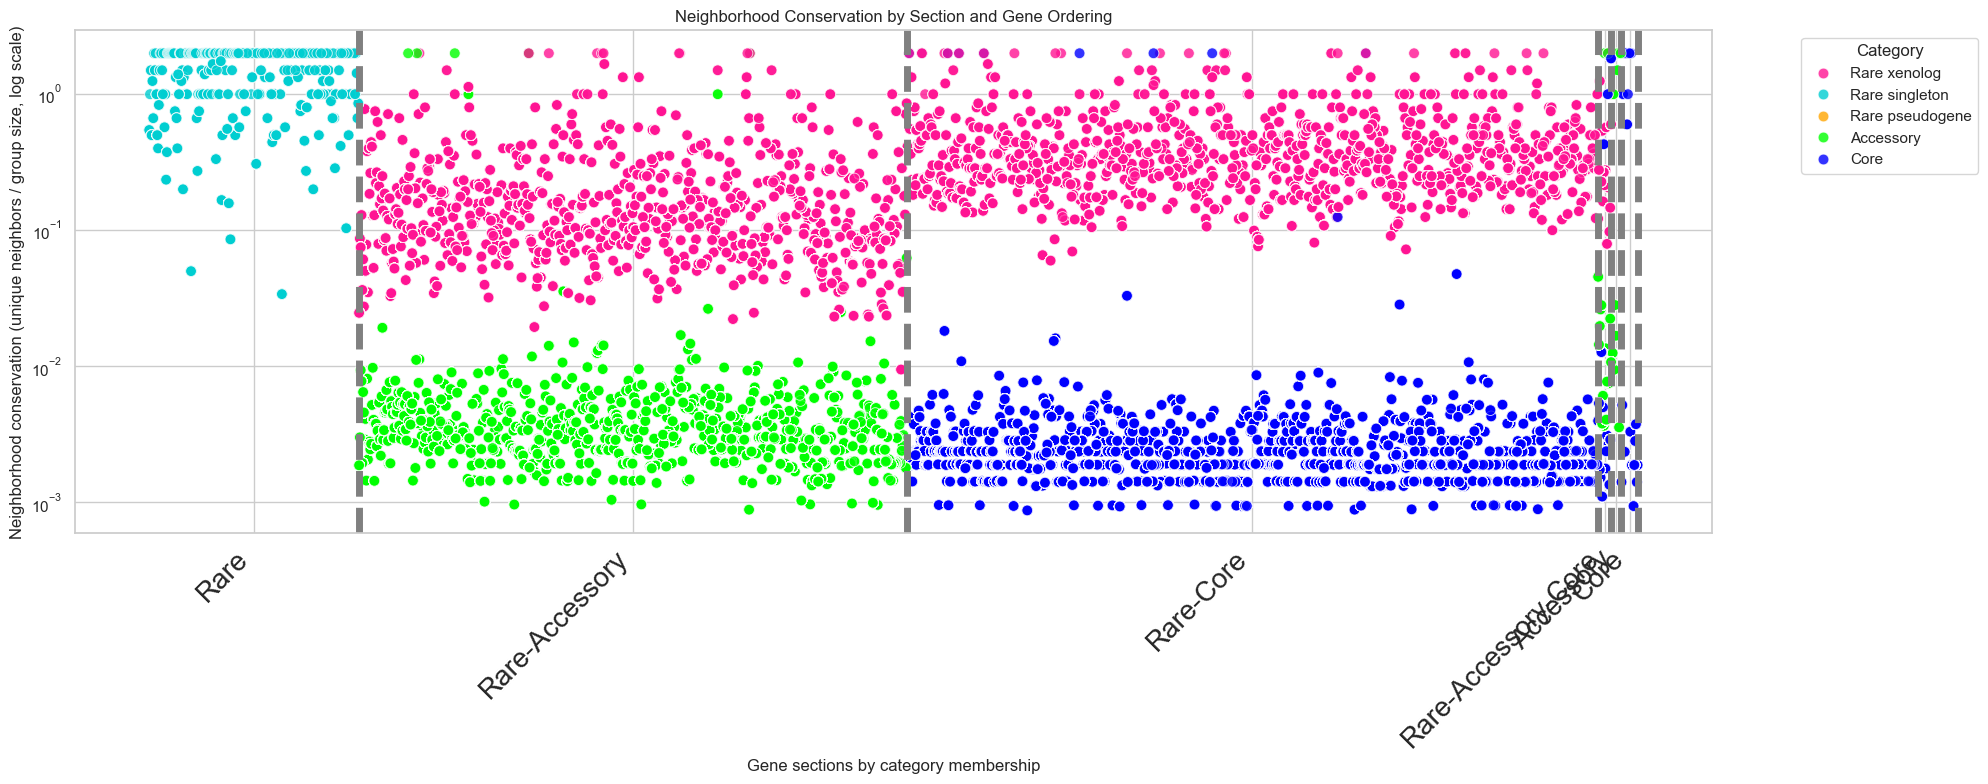

In [57]:
# Scatter for cleaned_ngn_labeled (same style/sections/colors as your old plot)
# - Uses your 5 fixed colors
# - Sections derived from `labels` (mapped to your old section names)
# - X ordering uses gene_gppr if available; otherwise falls back to median neighborhood_conservation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = cleaned_ngn_labeled.copy()

# ---------- 1) Map labels -> sections (to match your old section names) ----------
label_to_section = {
    "Only rare":        "Rare",
    "Rare-Acc":         "Rare-Accessory",
    "Rare-Core":        "Rare-Core",
    "Rare-Core-Acc":    "Rare-Accessory-Core",
    "Only accessory":   "Accessory",
    "Acc-core":         "Accessory-Core",
    "Only core":        "Core",
}
df["section"] = df["labels"].map(label_to_section)

# Keep only rows that map to a known section
df = df[df["section"].notna()].copy()

# ---------- 2) Determine section order present ----------
full_order = [
    "Rare", "Rare-Accessory", "Rare-Core", "Rare-Accessory-Core",
    "Accessory", "Accessory-Core", "Core"
]
present_sections = [sec for sec in full_order if sec in set(df["section"])]

# ---------- 3) Build x ordering per Target_Gene ----------
# Prefer gene_gppr for ordering if available; otherwise fallback to a robust proxy
if "gene_gppr" in globals() and isinstance(gene_gppr, (pd.Series, pd.DataFrame)):
    if isinstance(gene_gppr, pd.DataFrame) and gene_gppr.shape[1] == 1:
        gene_gppr = gene_gppr.squeeze("columns")
    gene_gppr = gene_gppr.astype(float)
    get_key = lambda g: gene_gppr.get(g, np.inf)  # unknowns go to the end
else:
    # Fallback: median neighborhood_conservation per gene (smaller first)
    med_nc = df.groupby("Target_Gene")["neighborhood_conservation"].median()
    get_key = lambda g: med_nc.get(g, np.inf)

ordered_genes     = []
section_boundaries = []
section_centers    = []
offset = 0

for sec in present_sections:
    genes = sorted(
        df.loc[df["section"].eq(sec), "Target_Gene"].unique().tolist(),
        key=get_key
    )
    n = len(genes)
    if n == 0:
        continue
    center = offset + (n - 1) / 2
    section_centers.append(center)
    offset += n
    section_boundaries.append(offset - 0.5)
    ordered_genes.extend(genes)

gene_to_x = {g: i for i, g in enumerate(ordered_genes)}
df["x"] = df["Target_Gene"].map(gene_to_x)

# ---------- 4) Marker colors: keep your exact 5-color order ----------
# Map your new categories to the old "marker_type" names to preserve color identity
cat_to_marker = {
    "Xenolog":     "Rare xenolog",
    "Singleton":   "Rare singleton",
    "Pseudogene":  "Rare pseudogene",
    "Accessory":   "Accessory",
    "Core":        "Core",
}
df["marker_type"] = df["category"].map(cat_to_marker).fillna("Rare pseudogene")

palette = ['#ff1493', '#00ced1', '#ffa500', '#00ff00', '#0000ff']
hue_order = ['Rare xenolog', 'Rare singleton', 'Rare pseudogene', 'Accessory', 'Core']
palette_map = {h: palette[i] for i, h in enumerate(hue_order)}

# ---------- 5) Plot ----------
sns.set_style("whitegrid")
plt.figure(figsize=(20, 8))

sns.scatterplot(
    data=df,
    x="x",
    y="neighborhood_conservation",
    hue="marker_type",
    hue_order=hue_order,
    palette=palette_map,
    s=60,
    alpha=0.8,
    legend="full"
)

plt.yscale("log")

# Section separators
for b in section_boundaries:
    plt.axvline(x=b, color="gray", linestyle="--", linewidth=5)

# X ticks at section centers
plt.xticks(section_centers, present_sections, rotation=45, ha="right", fontsize=20)

plt.xlabel("Gene sections by category membership")
plt.ylabel("Neighborhood conservation (unique neighbors / group size, log scale)")
plt.title("Neighborhood Conservation by Section and Gene Ordering")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
# plt.savefig('/Users/omidard/Desktop/neighborhood_conservation_by_section.svg', dpi=800, bbox_inches='tight')
plt.show()


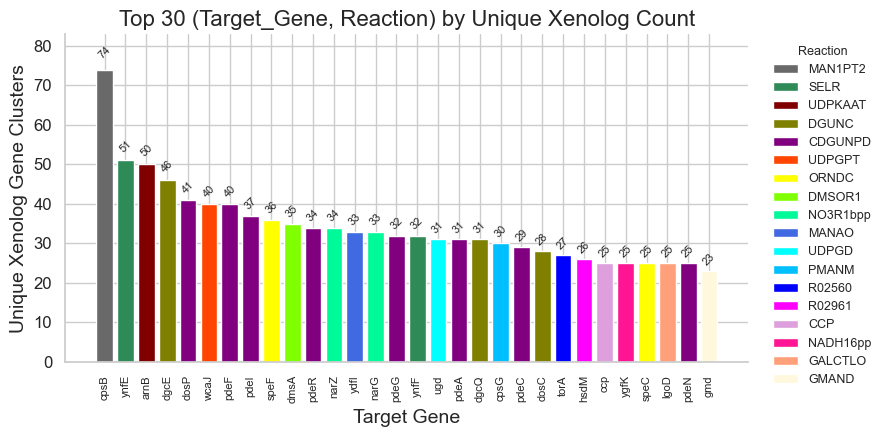

In [69]:
# Top-30 (Target_Gene, Reaction) pairs by UNIQUE xenolog gene_name
# x-axis: Target_Gene, color: Reaction  (same style as your pseudogene plot)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from itertools import cycle

# 1) Palette (same as yours)
palette = {
    'dimgray': '#696969','seagreen':'#2e8b57','maroon':'#800000','olive':'#808000',
    'purple':'#800080','orangered':'#ff4500','yellow':'#ffff00','chartreuse':'#7fff00',
    'mediumspringgreen':'#00fa9a','royalblue':'#4169e1','aqua':'#00ffff','deepskyblue':'#00bfff',
    'blue':'#0000ff','fuchsia':'#ff00ff','plum':'#dda0dd','deeppink':'#ff1493',
    'lightsalmon':'#ffa07a','cornsilk':'#fff8dc',
}

# 2) Filter to xenolog rows and normalize
xeno = cleaned_ngn_labeled[cleaned_ngn_labeled['category'].eq('Xenolog')].copy()
for c in ['Target_Gene','Reaction','gene_name']:
    xeno[c] = xeno[c].astype(str).str.strip()

# 3) De-duplicate by gene_name within each (Target_Gene, Reaction)
xeno_dedup = xeno.drop_duplicates(subset=['Target_Gene','Reaction','gene_name'])

# 4) Aggregate unique xenolog counts per (Target_Gene, Reaction)
xeno_agg = (
    xeno_dedup
    .groupby(['Target_Gene','Reaction'], dropna=False)
    .size()
    .reset_index(name='xenolog_count')
    .sort_values('xenolog_count', ascending=False)
)

# 5) Take top 30 rows
df30 = xeno_agg.head(30).copy()

# 6) Map Reaction -> color (cycle if more reactions than palette colors)
unique_rxns = df30['Reaction'].astype(str).unique().tolist()
color_iter = cycle(list(palette.values()))
color_map = {rxn: next(color_iter) for rxn in unique_rxns}

# 7) Plot (same layout as your pseudogene chart)
x = range(len(df30))
fig, ax = plt.subplots(figsize=(9, 4.5))
bars = ax.bar(
    x,
    df30['xenolog_count'].values,
    color=[color_map[str(r)] for r in df30['Reaction'].astype(str)],
    align='center'
)

# 8) Annotate counts
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2, h + max(1, 0.03*h),
        f"{int(h)}",
        ha='center', va='bottom', fontsize=8, rotation=45
    )

# 9) Axes/labels
ax.set_xlabel('Target Gene')
ax.set_ylabel('Unique Xenolog Gene Clusters')
ax.set_title('Top 30 (Target_Gene, Reaction) by Unique Xenolog Count')

ax.set_xticks(list(x))
ax.set_xticklabels(df30['Target_Gene'].astype(str), rotation=90, fontsize=8)
ax.set_ylim(0, df30['xenolog_count'].max() * 1.12)

# 10) Legend (Reaction colors)
legend_handles = [Patch(facecolor=color_map[str(r)], label=str(r)) for r in unique_rxns]
ax.legend(
    handles=legend_handles, title='Reaction',
    bbox_to_anchor=(1.02, 1), loc='upper left',
    fontsize=9, title_fontsize=9, frameon=False
)

plt.tight_layout()
# plt.savefig('/Users/omidard/Desktop/xenologs_top30_pairs_dedup.svg', dpi=800, bbox_inches='tight')
plt.show()


In [ ]:
"""
#Multiple sequence alingment and functional domain identification across different clusters with same annotation
Pipeline: cleaned_ngn -> unique gene_name per Target_Gene -> locus_tags -> sequences -> MSA -> similarity/coverage vs ref -> (optional) PFAM domains

Inputs (already in memory):
  - cleaned_ngn : DataFrame with at least ['Target_Gene','gene_name']
  - pangenome_df: DataFrame with columns ['locus_tag','Gene','Category']
  - FASTA file with protein sequences; headers start with locus_tag then '|' (or whitespace).
      Example: >CHHFFHHN_00002|1033813.3|...

Edit `FASTA_PATH` and PFAM config as needed.
This script:
  1) builds a unique set of gene_name per Target_Gene
  2) maps gene_name -> first locus_tag hit in pangenome_df
  3) pulls sequences from FASTA by locus_tag
  4) does per-Target_Gene multiple sequence alignment (MAFFT if available; else CLUSTALO; else center-star fallback)
  5) computes identity & coverage vs the longest sequence (reference)
  6) (optional) runs hmmscan on each sequence to get Pfam domains (requires PFAM DB installed)
  7) returns a combined DataFrame with metrics and saves per-target outputs to disk

Dependencies:
  - pandas, biopython
  - optional: MAFFT or CLUSTAL OMEGA in $PATH for high-quality MSA
  - optional: HMMER (hmmscan) + Pfam-A.hmm for domains
"""

import os
import tempfile
import subprocess
from pathlib import Path
from collections import defaultdict

import pandas as pd
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import pairwise2

# -------------------- CONFIG --------------------
FASTA_PATH = "/pangenome/cdhit_full_80.faa"  # update if needed
OUT_DIR = Path("/Data/ngn_msa_results")  # where to write alignments / tables
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Optional PFAM (set PFAM_DB to the path of Pfam-A.hmm if you want domains)
PFAM_HMM = os.environ.get("PFAM_DB", None)  # e.g., "/usr/local/share/pfam/Pfam-A.hmm"
# ------------------------------------------------

# 0) Helpers
def parse_locus_from_header(header: str) -> str:
    """
    Extract locus_tag from FASTA header.
    Assumes first 'word' (up to first space), then split by '|' and take [0].
    """
    first = header.split()[0]
    return first.split("|")[0]

def load_fasta_as_dict(fasta_path: str) -> dict:
    lut = {}
    with open(fasta_path) as handle:
        for rec in SeqIO.parse(handle, "fasta"):
            locus = parse_locus_from_header(rec.description)
            if locus not in lut:
                lut[locus] = str(rec.seq)
    return lut

def which(cmd: str) -> bool:
    return subprocess.call(["bash", "-lc", f"command -v {cmd} >/dev/null 2>&1"]) == 0

def write_tmp_fasta(records: list[SeqRecord]) -> str:
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".fasta")
    tmp.close()
    SeqIO.write(records, tmp.name, "fasta")
    return tmp.name

def run_mafft(in_fa: str) -> str:
    out_fa = tempfile.NamedTemporaryFile(delete=False, suffix=".fasta")
    out_fa.close()
    cmd = f"mafft --auto --quiet {in_fa} > {out_fa.name}"
    subprocess.check_call(["bash","-lc",cmd])
    return out_fa.name

def run_clustalo(in_fa: str) -> str:
    out_fa = tempfile.NamedTemporaryFile(delete=False, suffix=".fasta")
    out_fa.close()
    cmd = f"clustalo -i {in_fa} -o {out_fa.name} --force --threads=auto --outfmt=fasta --seqtype=Protein --quiet"
    subprocess.check_call(["bash","-lc",cmd])
    return out_fa.name

def center_star_align(seqs: dict[str, str], ref_id: str) -> dict[str, str]:
    """
    Very simple fallback MSA: align each sequence globally to the reference,
    then merge individual gapped alignments into a common reference-gapped coordinate frame.
    """
    # align ref to itself to seed gapped_ref
    ref_seq = seqs[ref_id]
    gapped_ref = ref_seq
    aligned = {ref_id: ref_seq}

    # We build a consensus ref-gap map; we will insert gaps into previous alignments as needed.
    for sid, s in seqs.items():
        if sid == ref_id: 
            continue
        # globalxx: identity scoring; tweak to globalms if desired
        a = pairwise2.align.globalxx(ref_seq, s, one_alignment_only=True)[0]
        ref_aln, s_aln = a.seqA, a.seqB

        # reconcile with current gapped_ref
        new_gapped_ref = []
        gap_idx = 0
        # expand existing aligned strings to match new ref_aln gaps
        expanded = {}
        for k, gseq in aligned.items():
            expanded[k] = []

        i_old = 0
        for i, ch in enumerate(ref_aln):
            if ch == "-":
                # insert gap into every existing aligned seq at this position
                new_gapped_ref.append("-")
                for k in expanded:
                    expanded[k].append("-")
            else:
                # advance one column from previous alignment strings
                new_gapped_ref.append(gapped_ref[i_old] if i_old < len(gapped_ref) else ch)
                for k in expanded:
                    exp_src = aligned[k]
                    expanded[k].append(exp_src[i_old] if i_old < len(exp_src) else "-")
                i_old += 1

        gapped_ref = "".join(new_gapped_ref)
        for k in aligned:
            aligned[k] = "".join(expanded[k])
        # now place the new sequence according to ref_aln
        # Build its aligned string in the new_gapped_ref frame
        s_out = []
        idx_s = 0
        for ch in ref_aln:
            if ch == "-":
                s_out.append("-")
            else:
                s_out.append(s_aln[idx_s])
                idx_s += 1
        aligned[sid] = "".join(s_out)

        # Update ref_seq to current gapped_ref for next iterations
        ref_seq = gapped_ref

    return aligned

def identity_and_coverage_vs_ref(gapped_ref: str, gapped_seq: str) -> tuple[float,float]:
    """
    Identity: matches to ref (same AA) / len(ref without gaps).
    Coverage: non-gap positions in query aligned to ref positions / len(ref without gaps).
    """
    ref_len = sum(1 for c in gapped_ref if c != "-")
    matches = 0
    covered = 0
    for r, q in zip(gapped_ref, gapped_seq):
        if r == "-":
            continue
        # ref has residue here
        if q != "-":
            covered += 1
            if q == r:
                matches += 1
    ident = matches / ref_len if ref_len else 0.0
    cov   = covered / ref_len if ref_len else 0.0
    return ident, cov

def run_hmmscan(seq_fa: str, pfam_hmm: str, cpu: int = 4) -> dict[str, list[tuple]]:
    """
    Run hmmscan against Pfam-A.hmm and parse --domtblout.
    Returns: {seq_id: [(acc, name, ali_start, ali_end, i_evalue)]}
    """
    if not pfam_hmm:
        return {}
    domtbl = tempfile.NamedTemporaryFile(delete=False, suffix=".domtbl")
    domtbl.close()
    cmd = f"hmmscan --cpu {cpu} --noali --domtblout {domtbl.name} {pfam_hmm} {seq_fa} >/dev/null"
    subprocess.check_call(["bash","-lc",cmd])
    hits = defaultdict(list)
    with open(domtbl.name) as fh:
        for line in fh:
            if line.startswith("#") or not line.strip():
                continue
            parts = line.strip().split()
            # domtblout standard columns
            target_name = parts[0]      # domain accession/name
            target_acc  = parts[1]
            query_name  = parts[3]
            i_eval      = float(parts[12])
            ali_start   = int(parts[17])
            ali_end     = int(parts[18])
            hits[query_name].append((target_acc, target_name, ali_start, ali_end, i_eval))
    return hits

# 1) Unique gene_name per Target_Gene
tg_to_genes = (
    cleaned_ngn.dropna(subset=["Target_Gene","gene_name"])
               .groupby("Target_Gene")["gene_name"]
               .agg(lambda s: sorted(set(map(str, s))))
)

# 2) Map gene_name -> first locus_tag from pangenome_df
gene_to_locus = {}
for gene, sub in pangenome_df.groupby("Gene"):
    # first locus_tag encountered
    gene_to_locus[str(gene)] = str(sub["locus_tag"].iloc[0])

# 3) Load FASTA into dict
locus_to_seq = load_fasta_as_dict(FASTA_PATH)

# 4) Iterate per Target_Gene, extract sequences, align, compute metrics
all_records = []  # to collect final rows

for tgt, genes in tg_to_genes.items():
    # Map to locus_tags (first hit) and fetch sequences
    pairs = []
    for g in genes:
        lt = gene_to_locus.get(g, None)
        if lt is not None and lt in locus_to_seq:
            pairs.append((g, lt, locus_to_seq[lt]))
    if len(pairs) < 2:
        # nothing to align, but still record what's available
        for g, lt, seq in pairs:
            all_records.append({
                "Target_Gene": tgt,
                "gene_name": g,
                "locus_tag": lt,
                "seq_len": len(seq),
                "is_reference": True,
                "identity_to_ref": 1.0,
                "coverage_to_ref": 1.0,
                "pfam_domains": ""
            })
        continue

    # Build SeqRecords
    seqrecs = [SeqRecord(Seq(seq), id=lt, description=g) for g, lt, seq in pairs]

    # Choose reference = longest sequence
    ref_idx = max(range(len(seqrecs)), key=lambda i: len(seqrecs[i].seq))
    ref_id  = seqrecs[ref_idx].id

    # Try MAFFT, then CLUSTALO, else center-star
    try:
        in_fa = write_tmp_fasta(seqrecs)
        if which("mafft"):
            out_fa = run_mafft(in_fa)
            aln = AlignIO.read(out_fa, "fasta")
        elif which("clustalo"):
            out_fa = run_clustalo(in_fa)
            aln = AlignIO.read(out_fa, "fasta")
        else:
            # fallback
            seqs = {rec.id: str(rec.seq) for rec in seqrecs}
            gapped = center_star_align(seqs, ref_id=ref_id)
            # convert to alignment-like access
            class SimpleAln: pass
            aln = SimpleAln()
            aln_dict = gapped
            aln.ids = list(aln_dict.keys())
            # store as dict for lookup below
            pass
        # If we used external aligners, turn into dict
        if 'aln_dict' not in locals():
            aln_dict = {rec.id: str(rec.seq) for rec in aln}  # gapped strings
    finally:
        try:
            if 'in_fa' in locals() and os.path.exists(in_fa): os.unlink(in_fa)
        except Exception:
            pass
        try:
            if 'out_fa' in locals() and os.path.exists(out_fa): os.unlink(out_fa)
        except Exception:
            pass

    gapped_ref = aln_dict[ref_id]

    # Optional: write aligned FASTA per target gene
    out_align = OUT_DIR / f"{tgt}_aligned.fasta"
    with open(out_align, "w") as fh:
        for g, lt, _seq in pairs:
            fh.write(f">{lt}|{g}\n{aln_dict[lt]}\n")

    # Compute identity & coverage vs ref for each sequence
    for g, lt, seq in pairs:
        ident, cov = identity_and_coverage_vs_ref(gapped_ref, aln_dict[lt])
        all_records.append({
            "Target_Gene": tgt,
            "gene_name": g,
            "locus_tag": lt,
            "seq_len": len(seq),
            "is_reference": (lt == ref_id),
            "identity_to_ref": ident,
            "coverage_to_ref": cov,
            "pfam_domains": ""  # filled below if hmmscan available
        })

# 5) Build DataFrame
msa_df = pd.DataFrame(all_records)

# 6) (Optional) PFAM annotation via hmmscan (only if PFAM_HMM set & hmmscan in PATH)
if PFAM_HMM and which("hmmscan"):
    # Write all unique sequences we used to a FASTA for hmmscan
    uniq_loci = msa_df["locus_tag"].dropna().unique().tolist()
    seq_out = OUT_DIR / "all_query_seqs.fasta"
    with open(seq_out, "w") as fh:
        for lt in uniq_loci:
            seq = locus_to_seq.get(lt, "")
            if seq:
                fh.write(f">{lt}\n{seq}\n")
    # Run hmmscan
    hits = run_hmmscan(str(seq_out), PFAM_HMM, cpu=os.cpu_count() or 4)
    # Merge back to msa_df (stringify domains)
    def fmt_domains(lst):
        if not lst: return ""
        # sort by i_evalue then by start
        lst = sorted(lst, key=lambda x: (x[4], x[2]))
        return "; ".join([f"{acc}:{name}[{s}-{e};E={ie:.1e}]" for acc,name,s,e,ie in lst])

    domain_map = {k: fmt_domains(v) for k, v in hits.items()}
    msa_df["pfam_domains"] = msa_df["locus_tag"].map(domain_map).fillna("")

# 7) Save combined table
out_tsv = OUT_DIR / "msa_similarity_coverage_pfam.tsv"
msa_df.to_csv(out_tsv, sep="\t", index=False)
print(f"[OK] Wrote table: {out_tsv}")
print(msa_df.head())

WARNING	Thread(Thread-6 (run)) choreographer.browser_async:browser_async.py:_close()- Resorting to unclean kill browser.


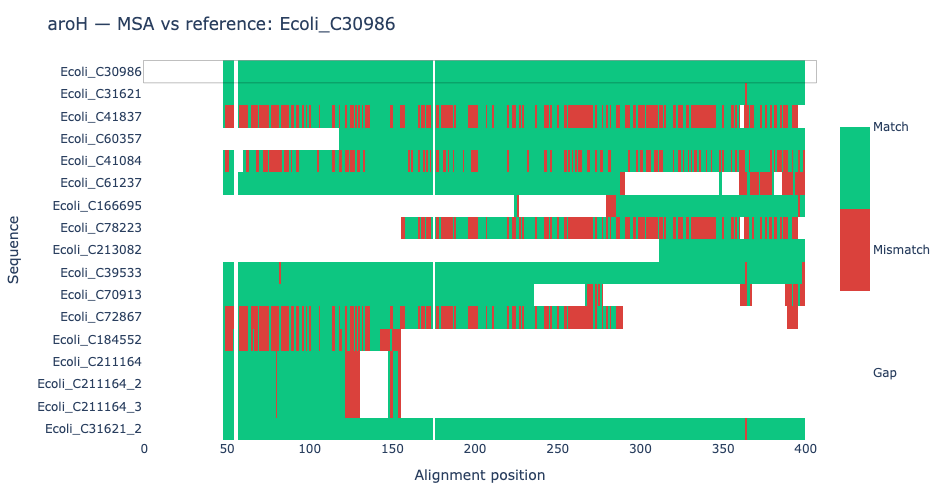

In [74]:
# COMPLETE, DROP-IN SCRIPT
# - Loads the longest (representative) sequence from each FASTA in a folder
# - Runs MSA with MAFFT (brew install mafft)
# - Builds a match/mismatch/gap matrix vs a chosen reference sequence
# - Plots a Plotly heatmap (your exact three-color scale) with optional ordering
# - Saves SVG (requires `pip install -U kaleido`)

import os
import re
import subprocess
import tempfile
from pathlib import Path
from typing import List

import numpy as np
import plotly.graph_objects as go
from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq


# ----------------------------
# Helpers
# ----------------------------
def _which(cmd: str) -> bool:
    return subprocess.call(["bash","-lc",f"command -v {cmd} >/dev/null 2>&1"]) == 0

def _write_fasta(records: List[SeqRecord]) -> str:
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".fasta")
    tmp.close()
    SeqIO.write(records, tmp.name, "fasta")
    return tmp.name

def _normalize_id(s: str) -> str:
    # strip whitespace and trailing commas in your inputs like "Ecoli_C31621,"
    return s.strip().rstrip(",")

def _header_to_id(header: str) -> str:
    """
    Extract a compact ID from a FASTA header.
    Strategy:
      - take first whitespace-delimited token
      - if it contains '|', take the first part (before pipe) (matches your locus_tag style)
    """
    tok = header.split()[0]
    return tok.split("|")[0]


# ----------------------------
# Load representative sequences
# ----------------------------
def load_largest_sequence_from_fasta(fp: str) -> SeqRecord:
    """
    Return the longest sequence in the FASTA file as a SeqRecord.
    ID is normalized from header using _header_to_id.
    """
    best = None
    for rec in SeqIO.parse(fp, "fasta"):
        if best is None or len(rec.seq) > len(best.seq):
            best = rec
    if best is None:
        raise ValueError(f"No sequences found in: {fp}")
    rid = _header_to_id(best.description)
    rec_out = SeqRecord(Seq(str(best.seq)), id=_normalize_id(rid), description="")
    return rec_out


# ----------------------------
# Multiple Sequence Alignment (MAFFT)
# ----------------------------
def perform_multiple_sequence_alignment(sequences: List[SeqRecord]):
    """
    Run MAFFT and return a BioPython MultipleSeqAlignment.
    Requires: brew install mafft
    """
    # sanitize IDs (unique and clean)
    seen = set()
    for r in sequences:
        r.id = _normalize_id(r.id)
        r.description = _normalize_id(r.description)
        # ensure uniqueness by appending a suffix if necessary
        if r.id in seen:
            suffix = 2
            base = r.id
            while f"{base}_{suffix}" in seen:
                suffix += 1
            r.id = f"{base}_{suffix}"
        seen.add(r.id)

    if not _which("mafft"):
        raise RuntimeError("MAFFT not found. Install with: brew install mafft")

    in_fa = _write_fasta(sequences)
    out_fa = tempfile.NamedTemporaryFile(delete=False, suffix=".fasta")
    out_fa.close()

    try:
        cmd = f"mafft --auto --anysymbol --thread -1 --quiet {in_fa} > {out_fa.name}"
        subprocess.check_call(["bash","-lc",cmd])
        aln = AlignIO.read(out_fa.name, "fasta")
        return aln
    finally:
        for p in (in_fa, out_fa.name):
            try:
                os.unlink(p)
            except Exception:
                pass


# ----------------------------
# Build match/mismatch/gap matrix vs reference
# ----------------------------
def alignment_to_matrix_vs_ref(alignment, ref_id: str):
    """
    Convert an alignment to a numeric matrix vs a chosen reference sequence.

    Returns:
      M (n_seq x n_cols) with values:
        0 = gap (either ref is gap at that column OR the query has a gap at a ref-residue column)
        1 = mismatch (query residue != ref residue at a ref-residue column)
        2 = match (query residue == ref residue at a ref-residue column)
      row_ids: ordered list of sequence IDs (same order as in the alignment)
      ref_index: index of the reference row in row_ids
    """
    ids = [rec.id for rec in alignment]
    if _normalize_id(ref_id) not in ids:
        raise ValueError(f"Reference id '{ref_id}' not found in alignment IDs: {ids}")

    ref_index = ids.index(_normalize_id(ref_id))
    ref_seq = str(alignment[ref_index].seq)
    n_seq = len(alignment)
    n_col = alignment.get_alignment_length()

    M = np.zeros((n_seq, n_col), dtype=np.int8)

    for c in range(n_col):
        r = ref_seq[c]
        if r == "-":
            # If the reference is a gap at this column, we mark the whole column as gap (0)
            # so these columns are visually "blank" (white) as per your colorscale.
            continue
        for i in range(n_seq):
            q = alignment[i, c]
            if q == "-":
                M[i, c] = 0  # gap
            elif q == r:
                M[i, c] = 2  # match
            else:
                M[i, c] = 1  # mismatch

    return M, ids, ref_index


# ----------------------------
# Plotting
# ----------------------------
def visualize_alignment(
    gene_name: str,
    alignment,
    core_gene_id: str,
    desired_order: List[str] = None,
    save_path: str = None,
    width: int = 800,
    height: int = 600,
):
    """
    Build a Plotly heatmap showing gaps/mismatches/matches vs a reference (core) sequence.
    Colors: white (gap), red (mismatch), green (match) – using your exact stops.
    """

    core_gene_id = _normalize_id(core_gene_id)
    M, ids, ref_idx = alignment_to_matrix_vs_ref(alignment, core_gene_id)

    # Order rows:
    order = []
    # 1) desired order first (if provided)
    if desired_order:
        desired_order = [_normalize_id(x) for x in desired_order]
        for k in desired_order:
            if k in ids and k not in order:
                order.append(k)
    # 2) ensure core (reference) is in the list (at the top if not already)
    if core_gene_id in ids and core_gene_id not in order:
        order = [core_gene_id] + order
    # 3) append any remaining sequences in their current alignment order
    for k in ids:
        if k not in order:
            order.append(k)

    # Reindex matrix rows to 'order'
    id_to_row = {sid: i for i, sid in enumerate(ids)}
    row_idx = [id_to_row[sid] for sid in order]
    M_ordered = M[row_idx, :]
    y_labels = order

    # Colorscale: 0 gap (white), 1 mismatch (red), 2 match (green)
    gap_color = 'white'
    mismatch_color = '#da413c'
    match_color = '#0dc681'
    custom_colorscale = [
        [0.00, gap_color],
        [0.333, gap_color],
        [0.334, mismatch_color],
        [0.666, mismatch_color],
        [0.667, match_color],
        [1.00, match_color],
    ]

    # Build heatmap
    fig = go.Figure(
        data=go.Heatmap(
            z=M_ordered,
            colorscale=custom_colorscale,
            zmin=0, zmax=2,
            showscale=True,
            colorbar=dict(
                tickmode='array',
                tickvals=[0, 1, 2],
                ticktext=['Gap', 'Mismatch', 'Match'],
                len=0.7
            ),
            hoverinfo='skip'  # can be set to 'z' or custom if you want per-cell hover
        )
    )

    fig.update_layout(
        title=f"{gene_name} — MSA vs reference: {core_gene_id}",
        xaxis=dict(
            title="Alignment position",
            showgrid=False,
            zeroline=False,
            mirror=False
        ),
        yaxis=dict(
            title="Sequence",
            tickmode='array',
            tickvals=np.arange(len(y_labels)),
            ticktext=y_labels,
            autorange='reversed'  # put first row at top
        ),
        width=width,
        height=height,
        plot_bgcolor="white",
        margin=dict(l=100, r=30, t=60, b=60)
    )

    # Optionally add a horizontal rule to highlight the reference row
    ref_row = y_labels.index(core_gene_id) if core_gene_id in y_labels else None
    if ref_row is not None:
        fig.add_shape(
            type="rect",
            x0=-0.5, x1=M_ordered.shape[1]-0.5,
            y0=ref_row-0.5, y1=ref_row+0.5,
            line=dict(color="rgba(0,0,0,0.25)", width=1),
            fillcolor="rgba(0,0,0,0)"
        )

    if save_path:
        # Requires: pip install -U kaleido
        fig.write_image(save_path)
    return fig


# ============================
# EXAMPLE USAGE
# ============================
if __name__ == "__main__":
    import glob

    # 1) Folder of FASTA files (each may have multiple sequences; we pick the longest from each)
    fasta_folder = "/Users/omidard/data/deep_input/msa_test/aroH/"
    fasta_files = sorted(glob.glob(os.path.join(fasta_folder, "*.fasta")))

    # 2) Load representatives
    representative_sequences = [load_largest_sequence_from_fasta(fp) for fp in fasta_files]

    # 3) Run MAFFT
    alignment = perform_multiple_sequence_alignment(representative_sequences)

    # 4) Desired order & core id (STRIP trailing commas from your list)
    desired_order = [
        'Ecoli_C31621,','Ecoli_C41837,','Ecoli_C60357,','Ecoli_C41084,','Ecoli_C61237,',
        'Ecoli_C166695,','Ecoli_C78223,','Ecoli_C213082,','Ecoli_C39533,','Ecoli_C70913,',
        'Ecoli_C72867,','Ecoli_C184552,','Ecoli_C211164,'
    ]
    desired_order = [_normalize_id(x) for x in desired_order]
    core_gene_id = _normalize_id('Ecoli_C30986,')

    # 5) Plot & save
    fig = visualize_alignment(
        gene_name="aroH",
        alignment=alignment,
        core_gene_id=core_gene_id,
        desired_order=desired_order,
        save_path="/Users/omidard/Desktop/aroH_alignment2xxx.svg",
        width=900,
        height=500
    )
    fig.show()


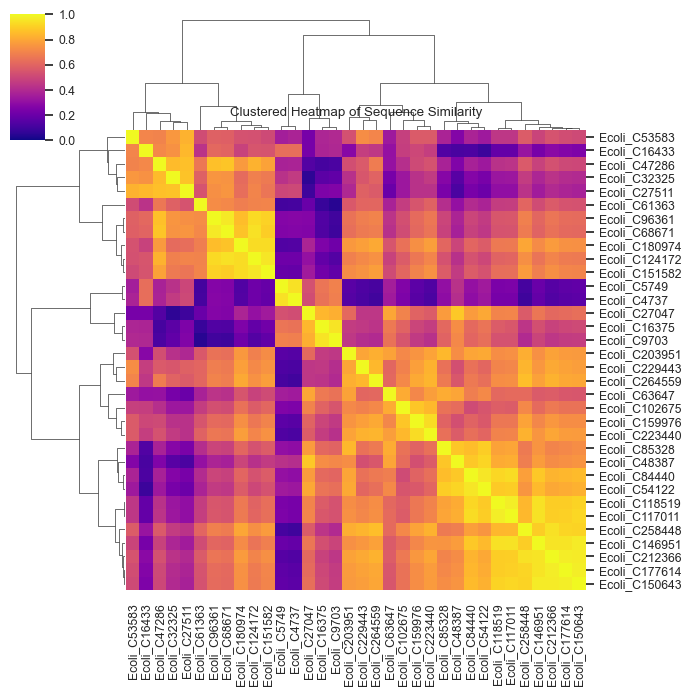

In [75]:
# COMPLETE MAFFT-BASED VERSION (no clustalo needed)
# - Picks longest sequence from each FASTA in a folder
# - Runs MSA with MAFFT (brew install mafft)
# - Computes pairwise Hamming similarity on the aligned sequences
# - Clusters with Ward linkage using the *distance* (1 - similarity)
# - Draws a seaborn clustermap and saves SVG

import os
import tempfile
import subprocess
from pathlib import Path

import numpy as np
from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Helpers
# --------------------------
def _which(cmd: str) -> bool:
    return subprocess.call(["bash","-lc", f"command -v {cmd} >/dev/null 2>&1"]) == 0

def _normalize_id(s: str) -> str:
    # strip whitespace and trailing commas (seen in your IDs)
    return str(s).strip().rstrip(",")

def _header_to_id(header: str) -> str:
    # Use first token; if it has pipes, take the left part (keeps locus_tag style)
    tok = header.split()[0]
    return tok.split("|")[0]

def load_largest_sequence_from_fasta(fasta_file: str) -> SeqRecord:
    """Return the single longest sequence as a SeqRecord with a clean ID."""
    best = None
    for rec in SeqIO.parse(fasta_file, "fasta"):
        if best is None or len(rec.seq) > len(best.seq):
            best = rec
    if best is None:
        raise ValueError(f"No sequences in {fasta_file}")
    rid = _normalize_id(_header_to_id(best.description))
    return SeqRecord(Seq(str(best.seq)), id=rid, description="")

def perform_msa(sequences):
    """Run MAFFT on a list of SeqRecord, return MultipleSeqAlignment."""
    if not _which("mafft"):
        raise RuntimeError("MAFFT not found. Install with: brew install mafft")

    # Ensure unique, clean IDs
    seen = set()
    for r in sequences:
        r.id = _normalize_id(r.id)
        if r.id in seen:
            # ensure uniqueness by suffixing
            base, k = r.id, 2
            while f"{base}_{k}" in seen:
                k += 1
            r.id = f"{base}_{k}"
        seen.add(r.id)

    with tempfile.NamedTemporaryFile(suffix=".fasta", delete=False) as tmp_in, \
         tempfile.NamedTemporaryFile(suffix=".fasta", delete=False) as tmp_out:
        SeqIO.write(sequences, tmp_in.name, "fasta")
        cmd = f"mafft --auto --anysymbol --thread -1 --quiet {tmp_in.name} > {tmp_out.name}"
        subprocess.check_call(["bash","-lc", cmd])
        aln = AlignIO.read(tmp_out.name, "fasta")

    # cleanup
    try: os.unlink(tmp_in.name)
    except Exception: pass
    try: os.unlink(tmp_out.name)
    except Exception: pass

    return aln

def compute_similarity_matrix(alignment):
    """
    Compute pairwise Hamming-based similarity on the aligned sequences.
    Similarity = 1 - HammingDistance(aligned_cols).
    Returns:
      sim_mat (n x n), labels (list of ids), dist_condensed (pdist 1-D vector)
    """
    labels = [rec.id for rec in alignment]
    # Convert alignment to array of characters (n_seq x n_cols)
    A = np.array([list(str(rec.seq)) for rec in alignment], dtype='<U1')

    # Map residues (including '-') to integers for pdist(hamming)
    residues = np.unique(A)
    code = {r:i for i, r in enumerate(residues)}
    X = np.vectorize(code.get)(A)  # n_seq x n_cols

    # Hamming distance is fraction of positions that differ (including gaps)
    dist_condensed = pdist(X, metric='hamming')
    dist_sq = squareform(dist_condensed)
    sim_mat = 1.0 - dist_sq
    return sim_mat, labels, dist_condensed

def plot_clustermap(sim_mat, labels, dist_condensed, out_svg: str):
    """
    Plot clustered heatmap using Ward linkage on the *distance* (1 - similarity).
    We compute a single linkage from the condensed distances and use it for both
    rows and cols to keep them synchronized.
    """
    # Ward requires Euclidean distances. Hamming is not Euclidean, but works OK in practice.
    Z = linkage(dist_condensed, method='ward')

    sns.set(font_scale=0.8)
    g = sns.clustermap(
        sim_mat,
        row_cluster=True,
        col_cluster=True,
        row_linkage=Z,
        col_linkage=Z,
        xticklabels=labels,
        yticklabels=labels,
        cmap='plasma',
        vmin=0.0, vmax=1.0,
        figsize=(7, 7)
    )
    g.ax_heatmap.set_title('Clustered Heatmap of Sequence Similarity', pad=10)
    Path(out_svg).parent.mkdir(parents=True, exist_ok=True)
    g.savefig(out_svg, format="svg", dpi=300, bbox_inches="tight")
    plt.show()

# --------------------------
# MAIN
# --------------------------
if __name__ == "__main__":
    fasta_folder = "/Users/omidard/data/deep_input/msa_test/R08991/dosP/"
    out_svg = "/Users/omidard/data/deep_input/msa_test/R08991/dosP/clustered_heatmap_dosP.svg"

    fasta_files = [os.path.join(fasta_folder, f)
                   for f in os.listdir(fasta_folder)
                   if f.endswith(".fasta")]

    # 1) Load representatives and run MAFFT
    reps = [load_largest_sequence_from_fasta(f) for f in fasta_files]
    aln  = perform_msa(reps)

    # 2) Compute similarity
    sim_mat, labels, dist_condensed = compute_similarity_matrix(aln)

    # 3) Plot
    plot_clustermap(sim_mat, labels, dist_condensed, out_svg)


In [80]:
#!/usr/bin/env python3
"""
One-shot script:
  1) Pick the longest (representative) sequence from each FASTA in a folder
  2) Write rep_seqs.fasta
  3) Make a gapless FASTA rep_seqs_clean.fasta
  4) Download Pfam-A.hmm (HTTPS) to ~/data/pfam and run hmmpress if needed
  5) Run hmmscan on rep_seqs_clean.fasta
  6) Parse domtblout and save a CSV summary

Requirements:
  - macOS/Homebrew HMMER installed: `brew install hmmer`  (provides hmmscan, hmmpress)
  - Biopython: `pip install biopython`
"""

import os
import sys
import gzip
import csv
import shutil
import urllib.request
import subprocess
from pathlib import Path
from typing import Dict, List, Tuple

from Bio import SeqIO, SearchIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


# ------------------------- USER CONFIG -------------------------
DATA_FOLDER = "/Users/omidard/data/deep_input/msa_test/R08991/pdeF"   # folder with many .fasta/.fa/.faa
PFAM_DIR    = str(Path.home() / "data" / "pfam")                      # where Pfam-A.hmm will live

REP_FASTA   = str(Path(DATA_FOLDER) / "rep_seqs.fasta")
CLEAN_FASTA = str(Path(DATA_FOLDER) / "rep_seqs_clean.fasta")
DOMTBLOUT   = str(Path(DATA_FOLDER) / "rep_seqs.domtblout")
CSV_OUT     = str(Path(DATA_FOLDER) / "rep_seqs_domains.csv")

CPU_COUNT   = max(1, os.cpu_count() or 4)
# ---------------------------------------------------------------


def which(cmd: str) -> bool:
    """Return True if executable is found on PATH."""
    return subprocess.call(["bash", "-lc", f"command -v {cmd} >/dev/null 2>&1"]) == 0


def collect_representative_sequences(folder: str, output: str) -> int:
    """
    For each FASTA-like file in `folder`, pick the longest sequence and write to `output`.
    Returns number of representatives written.
    """
    folder = Path(folder)
    reps: List[SeqRecord] = []

    for fname in sorted(folder.iterdir()):
        if not fname.is_file(): 
            continue
        if not fname.suffix.lower() in (".fasta", ".fa", ".faa"):
            continue

        seqs = list(SeqIO.parse(str(fname), "fasta"))
        if not seqs:
            continue

        longest = max(seqs, key=lambda s: len(s.seq))

        # Normalize an ID: take first token; if contains '|', keep leftmost (= locus tag style)
        rid = longest.description.split()[0].split("|")[0].strip().rstrip(",")
        reps.append(SeqRecord(Seq(str(longest.seq)), id=rid, description=""))

    if not reps:
        raise RuntimeError(f"No FASTA sequences found under: {folder}")

    SeqIO.write(reps, output, "fasta")
    return len(reps)


def clean_fasta_remove_gaps(in_fasta: str, out_fasta: str) -> int:
    """Remove '-' from sequences; return number of records written."""
    records: List[SeqRecord] = []
    for rec in SeqIO.parse(in_fasta, "fasta"):
        seq_str = str(rec.seq).replace("-", "")
        records.append(SeqRecord(Seq(seq_str), id=rec.id, description=""))
    if not records:
        raise RuntimeError(f"No sequences in {in_fasta}")
    SeqIO.write(records, out_fasta, "fasta")
    return len(records)


def setup_pfam(pfam_dir: str) -> str:
    """
    Ensure Pfam-A.hmm exists and is hmmpress-indexed. Return path to Pfam-A.hmm.
    Uses HTTPS (no FTP).
    """
    pfam_dir_path = Path(pfam_dir)
    pfam_dir_path.mkdir(parents=True, exist_ok=True)

    url = "https://ftp.ebi.ac.uk/pub/databases/Pfam/current_release/Pfam-A.hmm.gz"
    gz  = pfam_dir_path / "Pfam-A.hmm.gz"
    hmm = pfam_dir_path / "Pfam-A.hmm"

    if not gz.exists():
        print(f"[pfam] Downloading Pfam-A.hmm.gz → {gz}")
        urllib.request.urlretrieve(url, gz)

    if not hmm.exists():
        print(f"[pfam] Decompressing {gz} → {hmm}")
        with gzip.open(gz, "rb") as fin, open(hmm, "wb") as fout:
            shutil.copyfileobj(fin, fout)

    # hmmpress if any index file is missing
    exts = [".h3f", ".h3i", ".h3m", ".h3p"]
    indexed = all((hmm.with_suffix(hmm.suffix + e)).exists() for e in exts)
    if not indexed:
        if not which("hmmpress"):
            raise RuntimeError("hmmpress not found. Install HMMER: `brew install hmmer`.")
        print(f"[pfam] Running hmmpress on {hmm}")
        subprocess.run(["hmmpress", str(hmm)], check=True)

    return str(hmm)


def run_hmmscan(hmm_db: str, fasta: str, domtbl: str, cpu: int) -> None:
    """Run hmmscan --domtblout and write domtbl file."""
    if not which("hmmscan"):
        raise RuntimeError("hmmscan not found on PATH. Install HMMER: `brew install hmmer`.")

    if not Path(hmm_db).exists():
        raise FileNotFoundError(f"Pfam DB not found: {hmm_db}")
    if not Path(fasta).exists():
        raise FileNotFoundError(f"FASTA not found: {fasta}")

    cmd = [
        "hmmscan",
        "--domtblout", domtbl,
        "--cpu", str(cpu),
        hmm_db,
        fasta,
    ]
    print("[hmmscan]", " ".join(cmd))
    subprocess.run(cmd, check=True)
    print(f"[hmmscan] Done. Output: {domtbl}")


def parse_domtbl_to_csv(domtbl: str, csv_out: str) -> int:
    """
    Parse domtblout into a flat CSV:
      Sequence,Pfam_Accession,Evalue,AliStart,AliEnd,Pfam_Name
    Returns number of rows written.
    """
    rows = []
    for qresult in SearchIO.parse(domtbl, "hmmscan3-domtab"):
        qid = qresult.id
        for hit in qresult.hits:
            pfam_acc = hit.id           # e.g., PF00005.27
            pfam_name = hit.description # descriptive name (if provided)
            for hsp in hit.hsps:
                rows.append([
                    qid,
                    pfam_acc,
                    f"{hsp.evalue:.2e}",
                    hsp.query_range[0] + 1,
                    hsp.query_range[1],
                    pfam_name,
                ])

    Path(csv_out).parent.mkdir(parents=True, exist_ok=True)
    with open(csv_out, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["Sequence", "Pfam_Accession", "Evalue", "AliStart", "AliEnd", "Pfam_Name"])
        w.writerows(rows)

    print(f"[parse] Wrote {len(rows)} rows → {csv_out}")
    return len(rows)


def main():
    # 0) sanity: HMMER installed?
    if not which("hmmscan") or not which("hmmpress"):
        print("ERROR: HMMER not found. Install with Homebrew: `brew install hmmer`.", file=sys.stderr)
        sys.exit(1)

    # 1) representatives
    n = collect_representative_sequences(DATA_FOLDER, REP_FASTA)
    print(f"[reps] Wrote {n} representative sequences → {REP_FASTA}")

    # 2) gapless
    m = clean_fasta_remove_gaps(REP_FASTA, CLEAN_FASTA)
    print(f"[clean] Wrote {m} cleaned sequences → {CLEAN_FASTA}")

    # 3) Pfam setup (download/index if needed)
    pfam_hmm = setup_pfam(PFAM_DIR)
    print(f"[pfam] Using DB: {pfam_hmm}")

    # 4) hmmscan
    run_hmmscan(pfam_hmm, CLEAN_FASTA, DOMTBLOUT, CPU_COUNT)

    # 5) parse
    parse_domtbl_to_csv(DOMTBLOUT, CSV_OUT)

    print("[OK] Pipeline completed.")


if __name__ == "__main__":
    main()


[reps] Wrote 40 representative sequences → /Users/omidard/data/deep_input/msa_test/R08991/pdeF/rep_seqs.fasta
[clean] Wrote 40 cleaned sequences → /Users/omidard/data/deep_input/msa_test/R08991/pdeF/rep_seqs_clean.fasta
[pfam] Using DB: /Users/omidard/data/pfam/Pfam-A.hmm
[hmmscan] hmmscan --domtblout /Users/omidard/data/deep_input/msa_test/R08991/pdeF/rep_seqs.domtblout --cpu 8 /Users/omidard/data/pfam/Pfam-A.hmm /Users/omidard/data/deep_input/msa_test/R08991/pdeF/rep_seqs_clean.fasta
# hmmscan :: search sequence(s) against a profile database
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# query sequence file:             /Users/omidard/data/deep_input/msa_test/R08991/pdeF/rep_seqs_clean.fasta
# target HMM database:             /Users/omidard/data/pfam/Pfam-A.hmm
# per-dom hits tabular output:     /Users/omi

ValueError: The ID or alternative IDs of Hit 'MASE1' exists in this QueryResult.

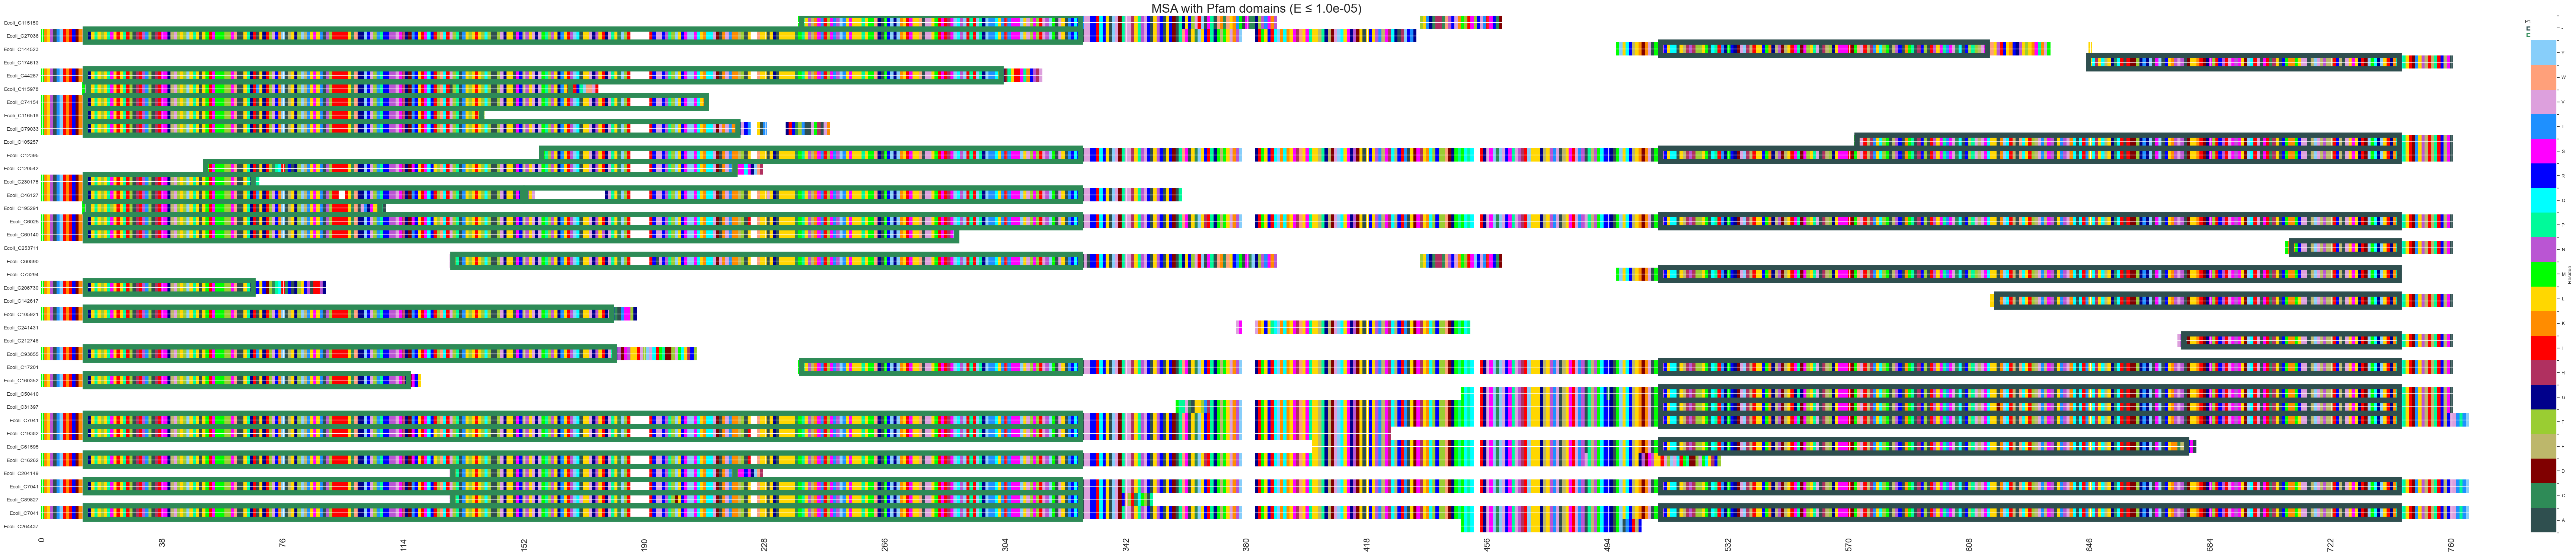

In [84]:
#!/usr/bin/env python3
"""
MSA + Pfam domain overlay (robust, single-file)

What it does
------------
1) Loads a gapped alignment FASTA.
2) Loads a Pfam domtbl CSV produced from hmmscan parsing (handles commas/semicolons,
   hyphenated column names, and duplicate headers).
3) Maps domain coordinates (ungapped, 1-based) onto alignment columns.
4) Draws an MSA heatmap (20 AA colors + white gaps) and overlays thick
   colored rectangles for domains. Saves SVG.

Edit the three paths below before running.

Requirements
------------
- Python 3
- numpy, pandas, matplotlib
"""

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle, Patch

# ===================== USER PATHS =====================
alignment_path = "/Users/omidard/data/deep_input/msa_test/R08991/pdeF/alignment_output.fasta"
domain_csv     = "/Users/omidard/data/deep_input/msa_test/R08991/pdeF/rep_seqs_domains.csv"
out_svg        = "/Users/omidard/data/deep_input/msa_test/R08991/pdeF/msa_with_domains.svg"
# ======================================================

# ================== VISUAL CONFIG =====================
FIG_SIZE = (80, 15)
EVALUE_THRESHOLD = 1e-5   # only annotate domains with E <= this
DOMAIN_STROKE = 10        # rectangle border width in points
Y_LABEL_FONTSIZE = 10
X_TICK_FONTSIZE = 16
TITLE_FONTSIZE  = 24
LEGEND_MAX = 25           # cap legend entries if many domains
# AA palette (20 AAs) + final entry = GAP color
PALETTE = [
    "#2f4f4f", "#2e8b57", "#800000", "#bdb76b", "#9acd32",
    "#00008b", "#b03060", "#ff0000", "#ff8c00", "#ffd700",
    "#00ff00", "#ba55d3", "#00fa9a", "#00ffff", "#0000ff",
    "#ff00ff", "#1e90ff", "#dda0dd", "#ffa07a", "#87cefa"
]
GAP_COLOR = "#ffffff"
# =====================================================

# Amino-acid order (20 canonical)
AA_ORDER = list("ACDEFGHIKLMNPQRSTVWY")
AA_TO_IDX = {aa: i for i, aa in enumerate(AA_ORDER)}
GAP_IDX = len(PALETTE)  # last color slot is gap (white)


# ----------------- FASTA READER -----------------
def read_fasta_records(path):
    """Return list[(seq_id, seq_string)] from a FASTA file."""
    records = []
    with open(path) as f:
        header, seq_lines = None, []
        for line in f:
            line = line.rstrip()
            if not line:
                continue
            if line.startswith(">"):
                if header:
                    records.append((header, "".join(seq_lines)))
                raw = line[1:]
                # normalize id: take first token, strip trailing commas
                norm = raw.split()[0].split(",")[0]
                header, seq_lines = norm, []
            else:
                seq_lines.append(line)
        if header:
            records.append((header, "".join(seq_lines)))
    if not records:
        raise RuntimeError(f"No sequences read from FASTA: {path}")
    return records


# -------------- DOMAIN CSV LOADER (ROBUST) --------------
def _normkey(s: str) -> str:
    return str(s).strip().lower().replace("-", "").replace(" ", "").replace("_", "")

def _read_csv_with_smart_sep(csv_path: str) -> pd.DataFrame:
    """
    Read CSV/semicolon/other-delimited files robustly.
    Tries: default, sep=None (sniff), explicit ';', explicit ','.
    """
    # try default (comma)
    try:
        df = pd.read_csv(csv_path)
        if df.shape[1] > 1:
            return df
    except Exception:
        pass

    # try python engine sniff
    try:
        df = pd.read_csv(csv_path, sep=None, engine="python")
        if df.shape[1] > 1:
            return df
    except Exception:
        pass

    # peek header to decide between ';' and ','
    with open(csv_path, "r", encoding="utf-8", errors="ignore") as fh:
        header = fh.readline().strip()
    if header.count(";") >= header.count(","):
        try:
            df = pd.read_csv(csv_path, sep=";")
            if df.shape[1] > 1:
                return df
        except Exception:
            pass

    # fallback to comma again (maybe quoted)
    df = pd.read_csv(csv_path, sep=",", engine="python")
    return df

def load_domain_hits(csv_path, evalue_threshold=1e-5) -> pd.DataFrame:
    """
    Load hmmscan-derived CSV and normalize column names automatically.
    Accepts headers like:
      - Sequence,Pfam_Accession,Evalue,AliStart,AliEnd,Pfam_Name
      - Sequence;Pfam_ID;E-value;Start;End;...
    Returns tidy DataFrame with columns:
      SequenceNorm, Pfam, Evalue, Start, End
    """
    df = _read_csv_with_smart_sep(csv_path)

    # If duplicate column names, make them unique (pandas adds .1 etc). We'll prefer first.
    if df.columns.duplicated().any():
        # Keep first occurrence values; drop duplicated columns
        df = df.loc[:, ~df.columns.duplicated()]

    # Build normalization dict
    colmap = {_normkey(c): c for c in df.columns}

    def pick(*cands):
        for c in cands:
            k = _normkey(c)
            if k in colmap:
                return colmap[k]
        raise KeyError(f"Missing columns {cands} in {list(df.columns)}")

    # likely alternatives (very permissive)
    c_seq   = pick("sequence", "query", "seqid", "target", "seq")
    c_acc   = pick("pfam_accession", "pfamacc", "pfamid", "pfamid", "pfam", "pfam_id", "hitid")
    c_eval  = pick("evalue", "evaluefull", "evaluei", "ievalue", "evaluecond", "evalue_dom", "evalueoverall", "evaluefullsequence", "evaluefull")
    # tolerate hyphenated E-value
    if c_eval not in df.columns and "E-value" in df.columns:
        c_eval = "E-value"

    # Start/End can be AliStart/AliEnd or Start/End
    try:
        c_start = pick("alistart", "ali_start", "start", "qstart")
    except KeyError:
        c_start = "AliStart" if "AliStart" in df.columns else pick("start")
    try:
        c_end = pick("aliend", "ali_end", "end", "qend")
    except KeyError:
        c_end = "AliEnd" if "AliEnd" in df.columns else pick("end")

    out = pd.DataFrame({
        "Sequence": df[c_seq].astype(str),
        "Pfam":     df[c_acc].astype(str),
        "Evalue":   pd.to_numeric(df[c_eval],  errors="coerce"),
        "Start":    pd.to_numeric(df[c_start], errors="coerce"),
        "End":      pd.to_numeric(df[c_end],   errors="coerce"),
    }).dropna(subset=["Evalue", "Start", "End"])

    # normalize to match FASTA IDs
    out["SequenceNorm"] = out["Sequence"].str.split().str[0].str.split(",").str[0]
    out["Start"] = out["Start"].astype(int)
    out["End"]   = out["End"].astype(int)

    # threshold filter
    out = out[out["Evalue"] <= evalue_threshold].copy()
    return out


# --------- BUILD ALIGNMENT MATRIX ---------
def build_alignment_matrix(seqs):
    """
    Convert list[str] aligned sequences to integer matrix for imshow.
    Known AAs map to 0..19, unknowns map to gap color; '-' maps to GAP_IDX (white).
    Returns (indices_matrix, aa_cmap, norm)
    """
    n = len(seqs)
    L = max(len(s) for s in seqs)
    idx = np.full((n, L), GAP_IDX, dtype=int)
    for i, s in enumerate(seqs):
        row = [AA_TO_IDX.get(ch, GAP_IDX) if ch != '-' else GAP_IDX for ch in s]
        idx[i, :len(row)] = row

    full_palette = PALETTE + [GAP_COLOR]
    cmap = ListedColormap(full_palette)
    norm = BoundaryNorm(np.arange(-0.5, len(full_palette)+0.5, 1), len(full_palette))
    return idx, cmap, norm


# --- MAP ungapped positions (1-based) -> alignment columns (0-based) ---
def build_pos_maps(ids_ord, seqs_ord):
    """
    For each aligned sequence, produce a dict:
      original_position(1-based, no gaps) -> alignment_column(0-based)
    """
    maps = {}
    for ridx, seq in enumerate(seqs_ord):
        pos_map = {}
        pos = 0
        for col, aa in enumerate(seq):
            if aa != '-':
                pos += 1
                pos_map[pos] = col
        maps[ids_ord[ridx]] = pos_map
    return maps


# ----------------- MAIN PLOT -----------------
def plot_msa_with_domains(
    ids_ord, seqs_ord, domain_df, out_svg_path,
    fig_size=FIG_SIZE, evalue_threshold=EVALUE_THRESHOLD
):
    idx, cmap, norm = build_alignment_matrix(seqs_ord)
    maps = build_pos_maps(ids_ord, seqs_ord)

    # domain dict: seq -> [(pfam, start, end, evalue), ...]
    domain_hits = {}
    for _, row in domain_df.iterrows():
        domain_hits.setdefault(row["SequenceNorm"], []).append(
            (row["Pfam"], int(row["Start"]), int(row["End"]), float(row["Evalue"]))
        )

    # domain palette (pfam -> color)
    all_domains = sorted({pf for hits in domain_hits.values() for pf,_,_,_ in hits})
    legend_domains = all_domains[:LEGEND_MAX]
    dom_to_color = {pf: PALETTE[i % len(PALETTE)] for i, pf in enumerate(all_domains)}

    fig, ax = plt.subplots(figsize=fig_size)
    ax.imshow(idx, cmap=cmap, norm=norm, aspect='auto', origin='upper')

    # y labels
    ax.set_yticks(np.arange(len(ids_ord)))
    ax.set_yticklabels(ids_ord, fontsize=Y_LABEL_FONTSIZE)
    ax.tick_params(axis='y', which='both', length=0)

    # x ticks (20 ticks max)
    L = idx.shape[1]
    step = max(1, L // 20)
    xticks = np.arange(0, L, step)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=90, fontsize=X_TICK_FONTSIZE)

    # overlay domain rectangles
    for row, sid in enumerate(ids_ord):
        for pf, start, end, e in domain_hits.get(sid, []):
            if e > evalue_threshold:
                continue
            col_map = maps.get(sid, {})
            c0 = col_map.get(start)
            c1 = col_map.get(end)
            if c0 is None or c1 is None:
                continue
            if c1 < c0:
                c0, c1 = c1, c0
            width = c1 - c0 + 1
            rect = Rectangle(
                (c0 - 0.5, row - 0.5),
                width, 1.0,
                linewidth=DOMAIN_STROKE,
                edgecolor=dom_to_color.get(pf, "#000000"),
                facecolor='none'
            )
            ax.add_patch(rect)

    # legend
    handles = [
        Patch(edgecolor=dom_to_color[pf], facecolor='none', label=pf, linewidth=2)
        for pf in legend_domains
    ]
    if handles:
        ax.legend(
            handles=handles,
            title='Pfam domains',
            bbox_to_anchor=(1.02, 1),
            loc='upper left',
            frameon=False
        )

    # colorbar for residues
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(cmap=cmap, norm=norm),
        ax=ax,
        ticks=np.arange(len(PALETTE)+1),
        pad=0.02
    )
    cbar.ax.set_yticklabels(AA_ORDER + ['-'])
    cbar.set_label('Residue', rotation=90)

    ax.set_title(f"MSA with Pfam domains (E ≤ {evalue_threshold:.1e})", fontsize=TITLE_FONTSIZE)
    fig.patch.set_facecolor('white'); ax.set_facecolor('white')
    plt.tight_layout()

    if out_svg_path:
        os.makedirs(os.path.dirname(out_svg_path), exist_ok=True)
        fig.savefig(out_svg_path, format="svg", dpi=300)
    plt.show()


# ================== RUN ==================
def main():
    # 1) load alignment
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Alignment FASTA not found: {alignment_path}")
    records = read_fasta_records(alignment_path)
    seq_ids, sequences = zip(*records)

    # order sequences by length (desc)
    order = np.argsort([len(s) for s in sequences])[::-1]
    ids_ord  = [seq_ids[i]   for i in order]
    seqs_ord = [sequences[i] for i in order]

    # 2) load domain CSV (robust column normalization)
    if not os.path.exists(domain_csv):
        print(f"[WARN] Domain CSV not found: {domain_csv}. Plotting alignment without domains.", file=sys.stderr)
        domain_df = pd.DataFrame(columns=["SequenceNorm", "Pfam", "Evalue", "Start", "End"])
    else:
        domain_df = load_domain_hits(domain_csv, evalue_threshold=EVALUE_THRESHOLD)

    # 3) plot
    plot_msa_with_domains(ids_ord, seqs_ord, domain_df, out_svg)


if __name__ == "__main__":
    main()
